In [1]:
import pandas as pd
import numpy as np
import csv
import re
import json
import string
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from nltk import word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [2]:
import tensorflow as tf

# 1. Import tweets

In [55]:
# Import tweets from tweepy cursor
py_df = pd.read_csv("py_tweets.csv")
nba_df = pd.read_csv("nba_tweets.csv")
py_tweets = list(py_df.iloc[:,1])
nba_tweets = list(nba_df.iloc[:,1])

In [56]:
# Import tweets from tweepy streaming
py_tweets_1 = []
for i in range(1,4):    
    with open("python_tweets_{}".format(i), "r") as f1:
        for line in f1:
            try:
                data = json.loads(line)
                # if you want to see a specific field, you can print it. 
                #If your file is big, there may be too many of these printed
                #print(data['text']) 
                py_tweets_1.append(data['text'].encode('utf-8'))
            except:
                continue

In [57]:
print("Total number of Python tweets:", len(py_tweets) + len(py_tweets_1))
print("Total number of NBA tweets:", len(nba_tweets))

Total number of Python tweets: 43810
Total number of NBA tweets: 21499


In [58]:
# Remove duplicate tweets
py_tweets = list(set(py_tweets))
py_tweets_1 = list(set(py_tweets_1))
nba_tweets = list(set(nba_tweets))
# Decode py_tweets_1 to strings
py_tweets_1 = [line.decode('utf-8') for line in py_tweets_1]
# Combine two lists
py_tweets = py_tweets + py_tweets_1

print("Total number of unique Python tweets:", len(py_tweets))
print("Total number of unique NBA tweets:", len(nba_tweets))

Total number of unique Python tweets: 10133
Total number of unique NBA tweets: 15251


# 2. Organize tweets

In [59]:
print('----- Tweets before cleaning -----\n')
print("Python: ")
for i in range(10,40,10):
    print("No.{}:\n".format(i), py_tweets[i], "\n")
print("NBA: ")
for i in range(10,40,10):
    print("No.{}:\n".format(i), nba_tweets[i], "\n")

----- Tweets before cleaning -----

Python: 
No.10:
 b'RT @DeschainXIV: Lets GOOO! @ianrufus is live on Twitch building a SaaS using #ReactJS #Python and other cool techs https://t.co/jzr6HRjU1Q\xe2\x80\xa6' 

No.20:
 b'"How to Create an Actionable SEO Dashboard with SEMRush and Python" https://t.co/f2PcQH22yb #jupyternotebook #python' 

No.30:
 b'\xf0\x9f\x90\x8d\xf0\x9f\x93\xb0 Absolute vs Relative Imports in Python \n\nIn this tutorial, you\xe2\x80\x99ll not only cover the pros and cons of absolute a\xe2\x80\xa6 https://t.co/PHYaHUfl95' 

NBA: 
No.10:
 b'Great move for BK. Depth they\xe2\x80\x99ll need when they empty the team for Harden #NBA https://t.co/cI5vXewSow' 

No.20:
 b'Congrats to Anthony Edwards #NBA https://t.co/WL2SkQCa0x' 

No.30:
 b'Great day for the Philadelphia 76ers. Add 2 sharpshooters in Danny Green and Seth Curry. Exactly what they needed. @sixers  #NBA' 



In [60]:
# Python
# Remove b' at the beginning
py_tweets = [re.sub(r'(b(\'|\")){1}', '', line) for line in py_tweets]
# Remove RT
py_tweets = [re.sub(r'RT\s', '', line) for line in py_tweets]
# Remove account name
py_tweets = [re.sub(r'@\w+:?\s*', '', line) for line in py_tweets]
# Remove newline 
py_tweets = [re.sub(r'\\n|\\t', ' ', line) for line in py_tweets]
# Remove url
py_tweets = [re.sub(r'https?://\S+', '', line) for line in py_tweets]
# Remove unicode
py_tweets = [re.sub(r'\\x\w{2}', '', line) for line in py_tweets]
# Remove continuous whitespace
py_tweets = [re.sub(r'\s+', ' ', line) for line in py_tweets]

# NBA
# Remove b' at the beginning
nba_tweets = [re.sub(r'(b(\'|\")){1}', '', line) for line in nba_tweets]
# Remove RT
nba_tweets = [re.sub(r'RT\s', '', line) for line in nba_tweets]
# Remove account name
nba_tweets = [re.sub(r'@\w+:?', '', line) for line in nba_tweets]
# Remove newline 
nba_tweets = [re.sub(r'\\n|\\t', ' ', line) for line in nba_tweets]
# Remove url
nba_tweets = [re.sub(r'https?://\S+', '', line) for line in nba_tweets]
# Remove unicode
nba_tweets = [re.sub(r'\\x\w{2}', '', line) for line in nba_tweets]
# Remove continuous whitespace
nba_tweets = [re.sub(r'\s+', ' ', line) for line in nba_tweets]

In [61]:
# Lowercase letters in tweets
py_tweets = [line.lower() for line in py_tweets]
nba_tweets = [line.lower() for line in nba_tweets]
# Remove hashtags
py_tweets = [re.sub(r'#python', '', line) for line in py_tweets]
nba_tweets = [re.sub(r'#nba', '', line) for line in nba_tweets]
# Remove non-alphanumeric characters
py_tweets = [re.sub(r'[^(a-zA-Z|\s)]', '', line) for line in py_tweets]
nba_tweets = [re.sub(r'[^(a-zA-Z|\s)]', '', line) for line in nba_tweets]

In [62]:
print("Python: ")
for i in range(10,40,10):
    print("No.{}:\n".format(i), py_tweets[i], "\n")

Python: 
No.10:
 lets gooo is live on twitch building a saas using reactjs  and other cool techs  

No.20:
 how to create an actionable seo dashboard with semrush and python jupyternotebook  

No.30:
  absolute vs relative imports in python in this tutorial youll not only cover the pros and cons of absolute a  



In [63]:
print("NBA: ")
for i in range(10,40,10):
    print("No.{}:\n".format(i), nba_tweets[i], "\n")

NBA: 
No.10:
 great move for bk depth theyll need when they empty the team for harden   

No.20:
 congrats to anthony edwards   

No.30:
 great day for the philadelphia ers add  sharpshooters in danny green and seth curry exactly what they needed  



In [64]:
# Check if there is any tweet with both hashtags
py_idx = []
for i in range(len(py_tweets)):
    if '#NBA' in py_tweets[i] or '#nba' in py_tweets[i]:
        py_idx.append(i)
nba_idx = []
for i in range(len(nba_tweets)):
    if '#Python' in nba_tweets[i] or '#python' in nba_tweets[i]:
        nba_idx.append(i)
print("Number of tweets with two hashtags:", len(py_idx)+len(nba_idx))

Number of tweets with two hashtags: 0


In [65]:
# We also remove Python and NBA from tweets' contexts
py_tweets = [re.sub(r'\s+python\s+|\s+python|python\s+', ' ', line) for line in py_tweets]
nba_tweets = [re.sub(r'\s+nba\s+|\s+nba|nba\s+', ' ', line) for line in nba_tweets]

# Remove tweets that are empty or only contain whitespace after filtering
py_empty_idx, nba_empty_idx = [], []
for i in range(len(py_tweets)):
    if py_tweets[i].isspace():
        py_empty_idx.append(i)
for i in range(len(nba_tweets)):
    if nba_tweets[i].isspace():
        nba_empty_idx.append(i)
py_tweets = [v for i,v in enumerate(py_tweets) if i not in py_empty_idx and len(py_tweets[i]) != 0] 
nba_tweets = [v for i,v in enumerate(nba_tweets) if i not in nba_empty_idx and len(nba_tweets[i]) != 0]

# Besides, we remove tweets that contain only stop words
stopset = stopwords.words('english') + list(string.punctuation)
pn = r'[A-Za-z]+'
remove_idx = []
for i in range(len(py_tweets)):
    line = py_tweets[i]
    words = regexp_tokenize(line, pattern=pn)
    count = 0
    for w in words:
        if w in stopset:
            count += 1
    if count == len(words):
        remove_idx.append(i)
py_tweets = [v for i,v in enumerate(py_tweets) if i not in remove_idx] 
remove_idx = []
for i in range(len(nba_tweets)):
    line = nba_tweets[i]
    words = regexp_tokenize(line, pattern=pn)
    count = 0
    for w in words:
        if w in stopset:
            count += 1
    if count == len(words):
        remove_idx.append(i)
nba_tweets = [v for i,v in enumerate(nba_tweets) if i not in remove_idx] 

In [66]:
all_tweets = py_tweets + nba_tweets
all_labels = ['python']*len(py_tweets) + ['nba']*len(nba_tweets)
print("Number of tweets:", len(all_tweets))
print("Number of labels:", len(all_labels))

Number of tweets: 25362
Number of labels: 25362


# 3. Split tweets into training (90%) and testing (10%) sets

In [67]:
x_train, x_test, y_train, y_test = train_test_split(all_tweets, all_labels, test_size=0.1, random_state=1)

In [68]:
print('Number of training tweets:', len(x_train))
print('Number of testing tweets:', len(x_test))
print('Number of trainging labels:', len(y_train))
print('Number of testing labels:', len(y_test))

Number of training tweets: 22825
Number of testing tweets: 2537
Number of trainging labels: 22825
Number of testing labels: 2537


In [69]:
print(x_train[0:10])
print(y_train[0:10])

['so good i had to share check out all the items im loving on from poshmark ', ' brewster academy alum malik fitts  has signed with clippernation  ', 'what  rookie are you most hype on with the draft on its way sportscards lamelo anthonyedwards obi ', 'nice pick up warriors ', ' insightful facts you didnt know about artificialintelligence datascience ', ' u saw the flag  draft', 'fall class statistics literature nursing biology psychology chemistry law psychology assignments homework', 'udemy free discount  hello react  react training for javascript beginners udemycoupon webdev', 'aaron nesmith officially joining the celtics ', 'when afl players get draftedyeah nah its good when  players get drafted gt ']
['nba', 'nba', 'nba', 'nba', 'python', 'nba', 'python', 'python', 'nba', 'nba']


In [70]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [71]:
# Assign "python" with 0, "nba" with 1 
y_train_a = np.where(y_train=='python', '0', y_train)
y_train_a = np.where(y_train=='nba', '1', y_train_a)


y_test_a = np.where(y_test=='python', '0', y_test)
y_test_a = np.where(y_test=='nba', '1', y_test_a)

# Convert string to number.
y_train_a = y_train_a.astype(np.int)
y_test_a = y_test_a.astype(np.int)

# 4. Construct word embeddings input

In [47]:
def calc_doc_embedding(doc, embeddings, embed_size, OOV_embed):
    # Cronstruct stopwords set
    stopset = stopwords.words('english') + list(string.punctuation)
    # Split the document
    words = doc.lower().split()
    # Get the vocabularies from the embedding matrix
    vocab_set = embeddings.vocab
    doc_embed = []
    for w in words:
        if w in stopset:
            continue
        if w in vocab_set:
            doc_embed.append(embeddings[w][:embed_size])
        else:
            if w not in OOV_embed:
                # Assign a random vector range from -1 to 1 as an embedding for w
                OOV_embed[w] = np.random.uniform(-1, 1, embed_size)            
            doc_embed.append(OOV_embed[w])
    # Convert list into numpy array and compute the centroid of words vectors
    doc_embed = np.mean(np.array(doc_embed), axis=0)
    return doc_embed
# Import word vectors
glove_file = datapath('/Users/seanhong/Desktop/Rutgers/Third Semester/Statistical Software/Project/glove.twitter.27B.50d.txt')
word2vec_text_file = get_tmpfile("glove.twitter.27B.50d.txt")
glove2word2vec(glove_file, word2vec_text_file)
mdl = KeyedVectors.load_word2vec_format(word2vec_text_file)
wv = mdl.wv
# Transform tweets input to word embedding input
OOV_embed = {} # Initialize OOV_embed to an empty dictionary
x_train_embed = np.vstack([calc_doc_embedding(doc, wv, 50, OOV_embed) for doc in x_train])
x_test_embed = np.vstack([calc_doc_embedding(doc, wv, 50, OOV_embed) for doc in x_test])
all_tweets_embed = np.vstack([calc_doc_embedding(doc, wv, 100, OOV_embed) for doc in all_tweets])

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


# 5. Naive Bayes

In [72]:
models_eval={}

Naive Bayes: (Input: TF-IDF) 

Predicted labels for test_data: ['python' 'python' 'nba' ... 'python' 'python' 'python']

Microaveraged F1 scores on test data: 0.9755616870319274
Macroaveraged F1 scores on test data: 0.9746661212078263 

Cross Validation: (5-fold)
Mean/SD of micro F1 scores: 0.9717689089451733 / 0.002573374091551264
Mean/SD of macro F1 scores: 0.9702648533093162 / 0.0027336383926298063


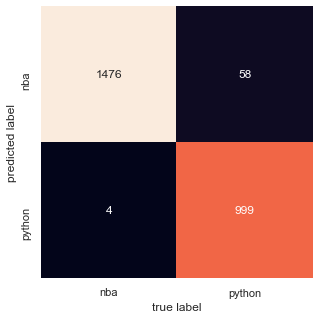

In [73]:
info = []

print("Naive Bayes: (Input: TF-IDF) \n")
nb_mod = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_mod.fit(x_train, y_train)
pred_labels = nb_mod.predict(x_test)
print("Predicted labels for test_data:", pred_labels)
# Confusion matrix
mat = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')
print('')
# F1 scores
print("Microaveraged F1 scores on test data:", f1_score(y_test, pred_labels, average='micro'))
print("Macroaveraged F1 scores on test data:", f1_score(y_test, pred_labels, average="macro"), '\n')
# Cross validation
print('Cross Validation: (5-fold)')
scores = cross_val_score(nb_mod, all_tweets, all_labels, cv=5, scoring='f1_micro')
print('Mean/SD of micro F1 scores:', scores.mean(), '/', scores.std())
nb_tf_scores = scores.copy()
info.append(scores.mean())
scores = cross_val_score(nb_mod, all_tweets, all_labels, cv=5, scoring='f1_macro')
print('Mean/SD of macro F1 scores:', scores.mean(), '/', scores.std())
info.append(scores.mean())

models_eval['Naive Bayes TF-IDF']=info

# 6. Logistic Regression

Logistic Regression: (Input: TF-IDF)

Predicted labels for test_data: ['python' 'python' 'nba' ... 'python' 'python' 'python']

Microaveraged F1 scores on test data: 0.9814741821048483
Macroaveraged F1 scores on test data: 0.9808996616725687 

Cross Validation: (5-fold)
Mean/SD of micro F1 scores: 0.9771705652675978 / 0.0017341603433233006
Mean/SD of macro F1 scores: 0.9761120635770386 / 0.001823082031287162


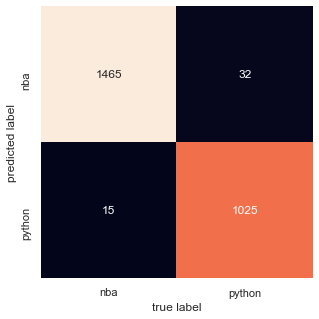

In [74]:
info = []

print("Logistic Regression: (Input: TF-IDF)\n")
lr_mod = make_pipeline(TfidfVectorizer(), LogisticRegression())
lr_mod.fit(x_train, y_train)
pred_labels = lr_mod.predict(x_test)
print("Predicted labels for test_data:", pred_labels)
# Confusion matrix
mat = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')
print('')
# F1 scores
print("Microaveraged F1 scores on test data:", f1_score(y_test, pred_labels, average='micro'))
print("Macroaveraged F1 scores on test data:", f1_score(y_test, pred_labels, average="macro"), '\n')
# Cross validation
print('Cross Validation: (5-fold)')
scores = cross_val_score(lr_mod, all_tweets, all_labels, cv=5, scoring='f1_micro')
print('Mean/SD of micro F1 scores:', scores.mean(), '/', scores.std())
lr_tf_scores = scores.copy()
info.append(scores.mean())
scores = cross_val_score(lr_mod, all_tweets, all_labels, cv=5, scoring='f1_macro')
print('Mean/SD of macro F1 scores:', scores.mean(), '/', scores.std())
info.append(scores.mean())

models_eval['Logistic Regression TF-IDF']=info

Logistic Regression: (Input: Word Embeddings)

Predicted labels for test_data: ['python' 'python' 'nba' ... 'python' 'python' 'python']

Microaveraged F1 scores on test data: 0.9562475364603863
Macroaveraged F1 scores on test data: 0.9550505644637255

Cross Validation: (5-fold)
Mean/SD of micro F1 scores: 0.9595456104284388 / 0.003558105466785461
Mean/SD of macro F1 scores: 0.9578273134947655 / 0.0037169818506640087


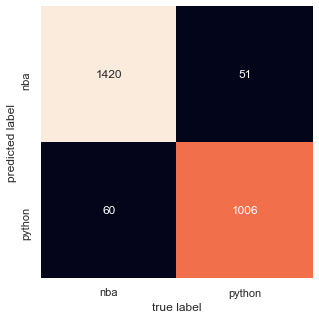

In [75]:
info = []

print("Logistic Regression: (Input: Word Embeddings)\n")
lr_mod_embed = LogisticRegression()
lr_mod_embed.fit(x_train_embed, y_train)
pred_labels = lr_mod_embed.predict(x_test_embed)
print("Predicted labels for test_data:", pred_labels)
# Confusion matrix
mat = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')
print('')
# F1 scores
print("Microaveraged F1 scores on test data:", f1_score(y_test, pred_labels, average='micro'))
print("Macroaveraged F1 scores on test data:", f1_score(y_test, pred_labels, average="macro"))
print('')
# Cross validation
print('Cross Validation: (5-fold)')
scores = cross_val_score(lr_mod_embed, all_tweets_embed, all_labels, cv=5, scoring='f1_micro')
print('Mean/SD of micro F1 scores:', scores.mean(), '/', scores.std())
lr_we_scores = scores.copy()
info.append(scores.mean())
scores = cross_val_score(lr_mod_embed, all_tweets_embed, all_labels, cv=5, scoring='f1_macro')
print('Mean/SD of macro F1 scores:', scores.mean(), '/', scores.std())
info.append(scores.mean())

models_eval['Logistic Regression Word Embeddings']=info

# 7.  Neural Network model  from sklearn

Neural Network: (Input: TF-IDF) 

Predicted labels of x_test: ['python' 'python' 'nba' ... 'python' 'python' 'python']

Microaveraged F1 scores on test data: 0.9885691761923532
Macroaveraged F1 scores on test data: 0.9882375286036068

Cross Validation: (5-fold)
Mean/SD of micro F1 scores: 0.9867517835811661 / 0.0015194302386697485
Mean/SD of macro F1 scores: 0.9863378309972397 / 0.0014772304776543782


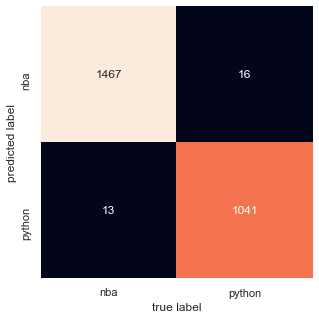

In [52]:
info = []


# One hidden layer with 50 units
print("Neural Network: (Input: TF-IDF) \n")
mlp_mod = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50,)))
mlp_mod.fit(x_train, y_train)
pred_labels = mlp_mod.predict(x_test)
print("Predicted labels of x_test:", pred_labels)
# Confusion matrix
mat = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')
print('')
# F1 scores
print("Microaveraged F1 scores on test data:", f1_score(y_test, pred_labels, average='micro'))
print("Macroaveraged F1 scores on test data:", f1_score(y_test, pred_labels, average="macro"))
print('')
# Cross validation
print('Cross Validation: (5-fold)')
scores = cross_val_score(mlp_mod, all_tweets, all_labels, cv=5, scoring='f1_micro', n_jobs=-1)
print('Mean/SD of micro F1 scores:', scores.mean(), '/', scores.std())
nn_tf_scores = scores.copy()
info.append(scores.mean())
scores = cross_val_score(mlp_mod, all_tweets, all_labels, cv=5, scoring='f1_macro', n_jobs=-1)
print('Mean/SD of macro F1 scores:', scores.mean(), '/', scores.std())
info.append(scores.mean())

models_eval['Neural Network TF-IDF']=info

Neural Network: (Input: Word Embeddings)

Predicted labels of x_test: ['python' 'python' 'nba' ... 'python' 'python' 'python']

Microaveraged F1 scores on test data: 0.9724083563263697
Macroaveraged F1 scores on test data: 0.9716497577322616

Cross Validation: (5-fold)
Mean/SD of micro F1 scores: 0.969600139229085 / 0.0037875205130559263
Mean/SD of macro F1 scores: 0.96985139558965 / 0.004719425611947547


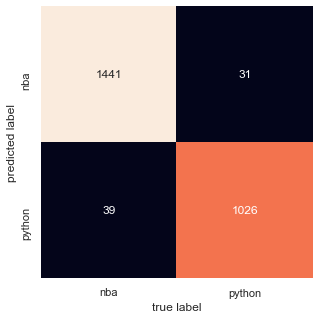

In [53]:
info = []

# One hidden layer with 50 units
print("Neural Network: (Input: Word Embeddings)\n")
mlp_mod_embed = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)
mlp_mod_embed.fit(x_train_embed, y_train)
pred_labels = mlp_mod_embed.predict(x_test_embed)
print("Predicted labels of x_test:", pred_labels)
# Confusion matrix
mat = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')
print('')
# F1 scores
print("Microaveraged F1 scores on test data:", f1_score(y_test, pred_labels, average='micro'))
print("Macroaveraged F1 scores on test data:", f1_score(y_test, pred_labels, average="macro"))
print('')
# Cross validation
print('Cross Validation: (5-fold)')
scores = cross_val_score(mlp_mod_embed, all_tweets_embed, all_labels, cv=5, scoring='f1_micro')
print('Mean/SD of micro F1 scores:', scores.mean(), '/', scores.std())
nn_we_scores = scores.copy()
info.append(scores.mean())
scores = cross_val_score(mlp_mod_embed, all_tweets_embed, all_labels, cv=5, scoring='f1_macro')
print('Mean/SD of macro F1 scores:', scores.mean(), '/', scores.std())
info.append(scores.mean())

models_eval['Neural Network Word Embeddings']=info

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


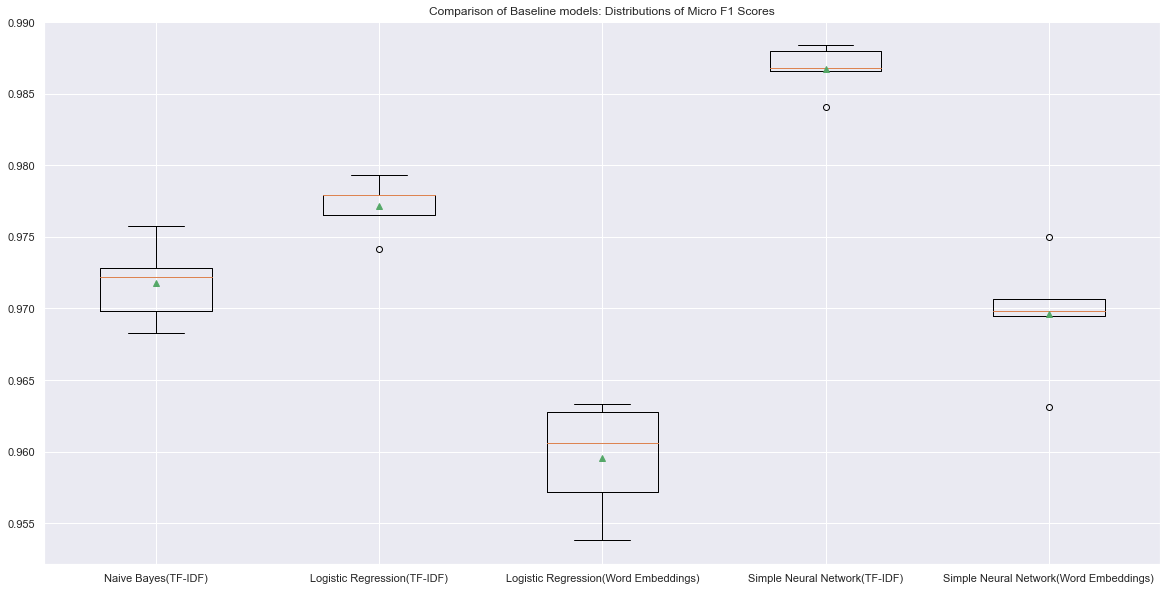

In [54]:
#Create a figure instance
fig = plt.figure(1, figsize=(20, 10))
# Create an axes instance
axes = fig.add_subplot(111)
# Create the titile and labels
mod_names = ['Naive Bayes(TF-IDF)', 'Logistic Regression(TF-IDF)', 'Logistic Regression(Word Embeddings)', 
          'Simple Neural Network(TF-IDF)', 'Simple Neural Network(Word Embeddings)']
axes.set_xticklabels(mod_names)
axes.set_title("Comparison of Baseline models: Distributions of Micro F1 Scores")
# Create the boxplot
bp = axes.boxplot([nb_tf_scores, lr_tf_scores, lr_we_scores, nn_tf_scores, nn_we_scores], showmeans=True)

# 8. Tensorflow

## 8.1 Model0: Neural Network One hidden layer with 50 units

In [27]:
# Apply k fold cross validation
from sklearn.model_selection import KFold

In [28]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#### Start with 10 hidden units

In [29]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 1s 752us/step - loss: 0.2240 - accuracy: 0.9129 - val_loss: 0.1586 - val_accuracy: 0.9371
Epoch 2/10
1826/1826 [==============================] - 1s 673us/step - loss: 0.1609 - accuracy: 0.9369 - val_loss: 0.1521 - val_accuracy: 0.9391
Epoch 3/10
1826/1826 [==============================] - 1s 619us/step - loss: 0.1542 - accuracy: 0.9383 - val_loss: 0.1482 - val_accuracy: 0.9395
Epoch 4/10
1826/1826 [==============================] - 1s 612us/step - loss: 0.1497 - accuracy: 0.9402 - val_loss: 0.1407 - val_accuracy: 0.9441
Epoch 5/10
1826/1826 [==============================] - 1s 668us/step - loss: 0.1456 - accuracy: 0.9427 - val_loss: 0.1373 - val_accuracy: 0.9472
Epoch 6/10
1826/1826 [==============================] - 1s 658us/step - loss: 0.1420 - accuracy: 0.9450 - val_loss: 0.1351 - val_accuracy: 0.9492
Epoch 7/10
1826/1826 [=====

Epoch 5/10
1826/1826 [==============================] - 1s 629us/step - loss: 0.1455 - accuracy: 0.9407 - val_loss: 0.1462 - val_accuracy: 0.9417
Epoch 6/10
1826/1826 [==============================] - 1s 667us/step - loss: 0.1423 - accuracy: 0.9438 - val_loss: 0.1440 - val_accuracy: 0.9433
Epoch 7/10
1826/1826 [==============================] - 1s 575us/step - loss: 0.1396 - accuracy: 0.9447 - val_loss: 0.1416 - val_accuracy: 0.9465
Epoch 8/10
1826/1826 [==============================] - 1s 680us/step - loss: 0.1376 - accuracy: 0.9446 - val_loss: 0.1414 - val_accuracy: 0.9463
Epoch 9/10
1826/1826 [==============================] - 1s 625us/step - loss: 0.1354 - accuracy: 0.9461 - val_loss: 0.1413 - val_accuracy: 0.9455
Epoch 10/10
143/143 [==============================] - 0s 481us/step - loss: 0.1374 - accuracy: 0.9465
Test Loss: 0.13740716874599457
Test Accuracy: 0.9465498328208923


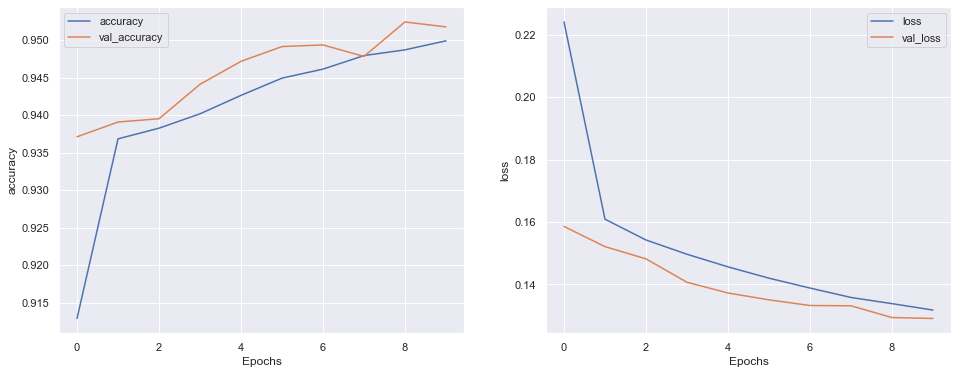

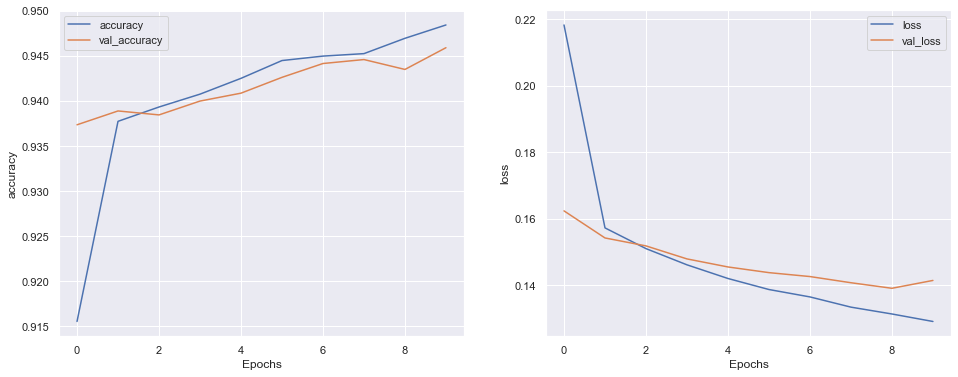

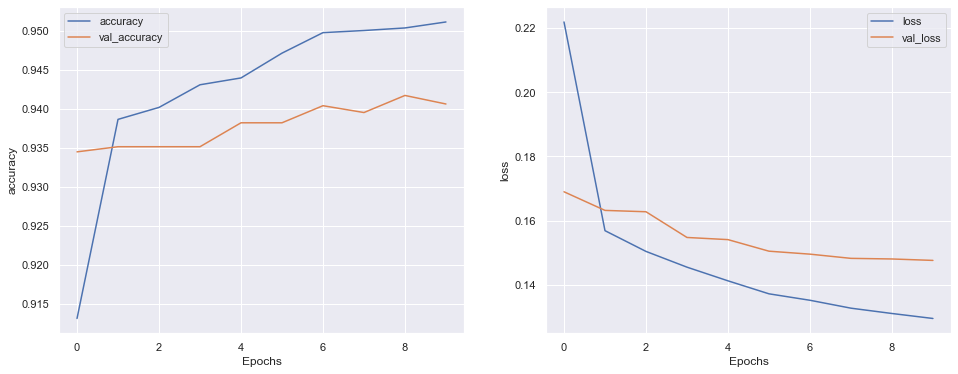

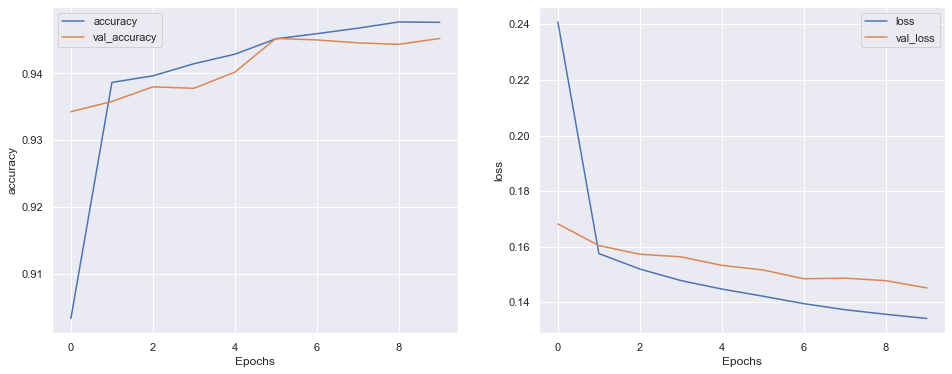

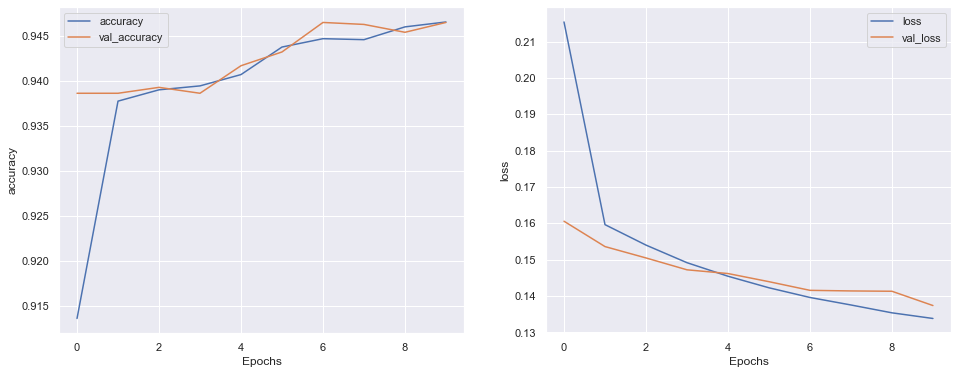

In [30]:
# Cross validation on model0
vals = kfold.split(x_train_embed, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train_embed[train_i]
    x_train_val = x_train_embed[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    # Build model with 10 hidden layer
    model0 = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model0.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    # Fit model with training and validation data
    history = model0.fit(x_train_train, y_train_train,
                  epochs=10,
                  batch_size=10,
                  verbose=1,
                  validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model0.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

In [31]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.12912043929100037 - Accuracy: 95.18072009086609%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.141457200050354 - Accuracy: 94.58926320075989%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.14753536880016327 - Accuracy: 94.06352639198303%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.14518380165100098 - Accuracy: 94.52354907989502%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.13740716874599457 - Accuracy: 94.65498328208923%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 94.60240840911865% (+- 0.35608817369128465)
> Loss: 0.14014079570770263
----------------------

#### 50 hidden units

In [32]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 2s 827us/step - loss: 0.1924 - accuracy: 0.9251 - val_loss: 0.1475 - val_accuracy: 0.9424
Epoch 2/10
1826/1826 [==============================] - 1s 669us/step - loss: 0.1526 - accuracy: 0.9398 - val_loss: 0.1414 - val_accuracy: 0.9437
Epoch 3/10
1826/1826 [==============================] - 1s 602us/step - loss: 0.1415 - accuracy: 0.9440 - val_loss: 0.1328 - val_accuracy: 0.9516
Epoch 4/10
1826/1826 [==============================] - 1s 605us/step - loss: 0.1315 - accuracy: 0.9491 - val_loss: 0.1293 - val_accuracy: 0.9520
Epoch 5/10
1826/1826 [==============================] - 1s 610us/step - loss: 0.1243 - accuracy: 0.9525 - val_loss: 0.1214 - val_accuracy: 0.9520
Epoch 6/10
1826/1826 [==============================] - 1s 643us/step - loss: 0.1175 - accuracy: 0.9551 - val_loss: 0.1221 - val_accuracy: 0.9533
Epoch 7/10
1826/1826 [=====

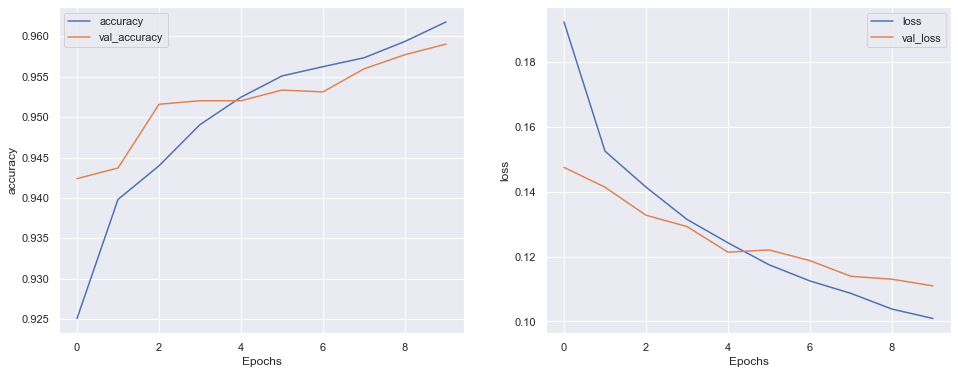

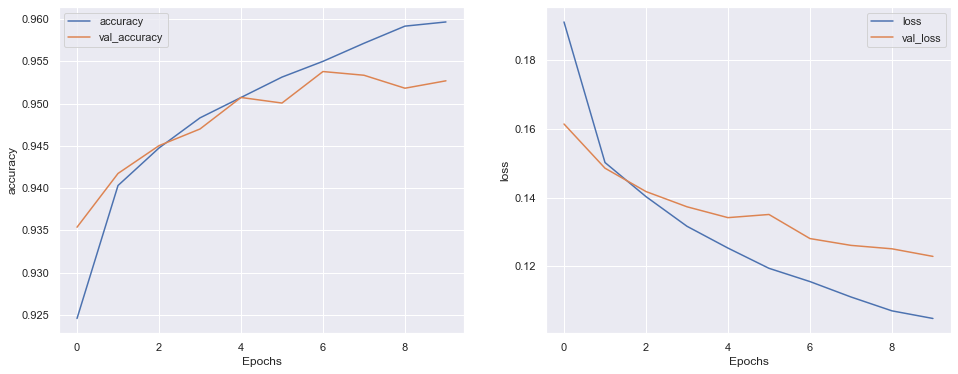

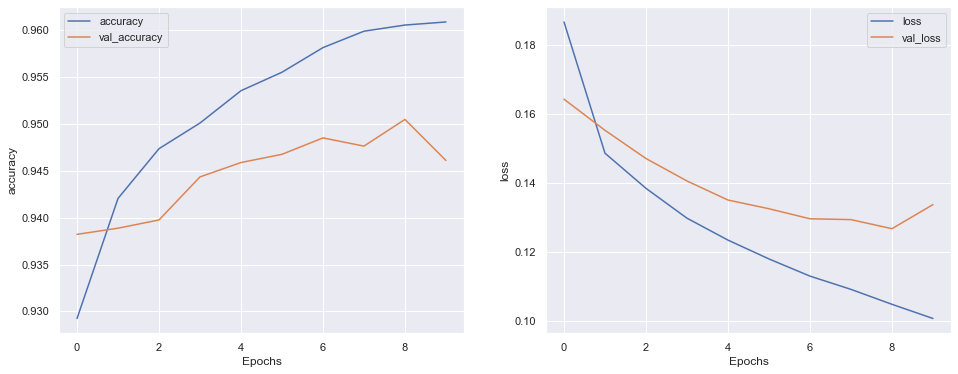

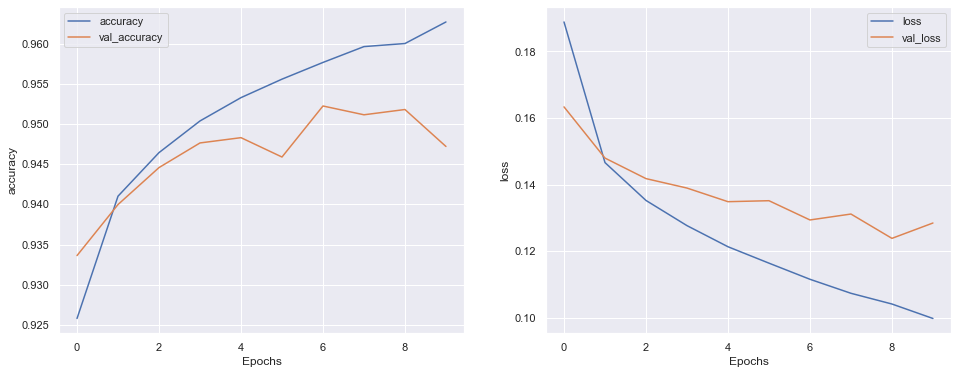

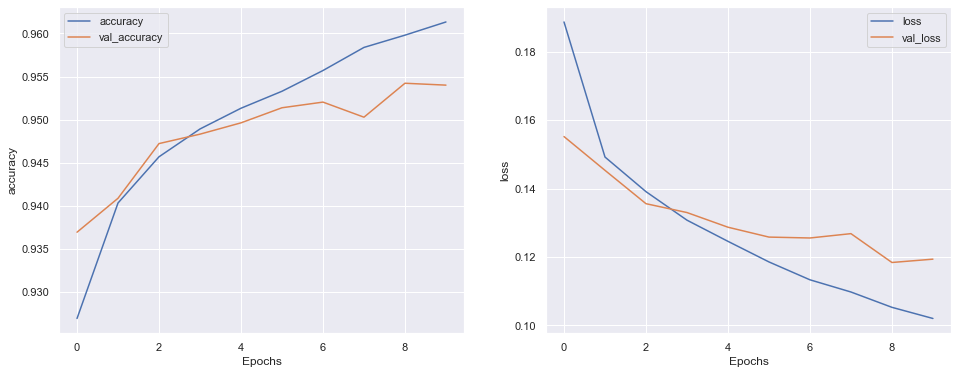

In [33]:
# Cross validation on model0
vals = kfold.split(x_train_embed, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train_embed[train_i]
    x_train_val = x_train_embed[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    # Build model with 50 hidden units
    model0 = tf.keras.Sequential([
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model0.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    # Fit model with training and validation data
    history = model0.fit(x_train_train, y_train_train,
                  epochs=10,
                  batch_size=10,
                  verbose=1,
                  validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model0.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

In [34]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.11098355799913406 - Accuracy: 95.90361714363098%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.1229034960269928 - Accuracy: 95.26834487915039%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.1338343620300293 - Accuracy: 94.61117386817932%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.12846386432647705 - Accuracy: 94.72070336341858%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.11938618123531342 - Accuracy: 95.3997790813446%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 95.18072366714478% (+- 0.47206850836967207)
> Loss: 0.12311429232358932
-----------------------

#### 100 hidden units

In [35]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 1s 602us/step - loss: 0.1808 - accuracy: 0.9286 - val_loss: 0.1466 - val_accuracy: 0.9424
Epoch 2/10
1826/1826 [==============================] - 1s 554us/step - loss: 0.1452 - accuracy: 0.9434 - val_loss: 0.1330 - val_accuracy: 0.9485
Epoch 3/10
1826/1826 [==============================] - 1s 539us/step - loss: 0.1334 - accuracy: 0.9479 - val_loss: 0.1255 - val_accuracy: 0.9542
Epoch 4/10
1826/1826 [==============================] - 1s 532us/step - loss: 0.1236 - accuracy: 0.9534 - val_loss: 0.1239 - val_accuracy: 0.9540
Epoch 5/10
1826/1826 [==============================] - 1s 553us/step - loss: 0.1163 - accuracy: 0.9558 - val_loss: 0.1196 - val_accuracy: 0.9544
Epoch 6/10
1826/1826 [==============================] - 1s 585us/step - loss: 0.1096 - accuracy: 0.9579 - val_loss: 0.1220 - val_accuracy: 0.9553
Epoch 7/10
1826/1826 [=====

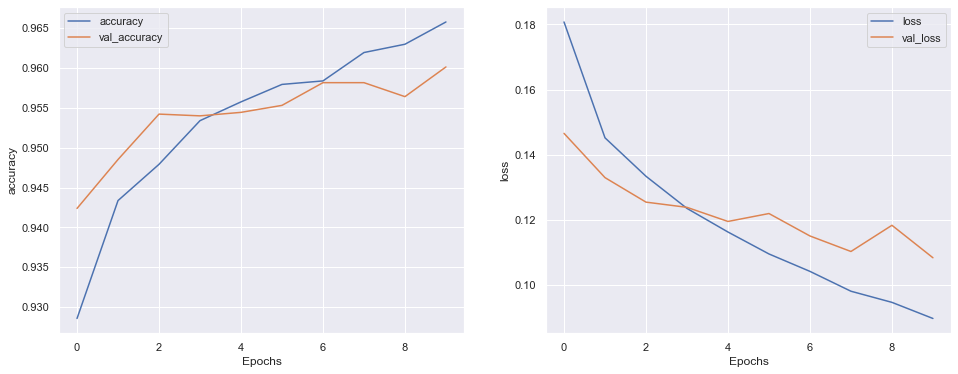

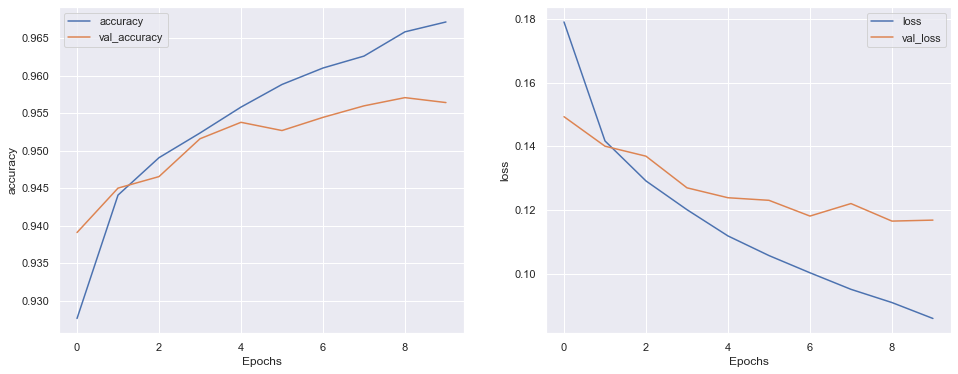

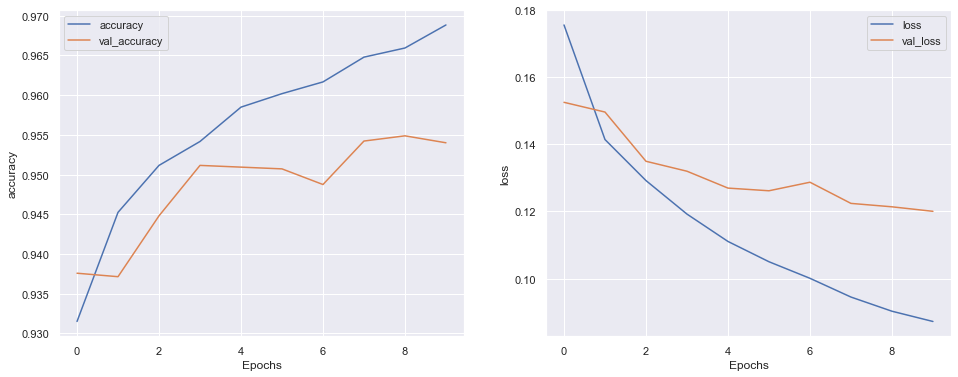

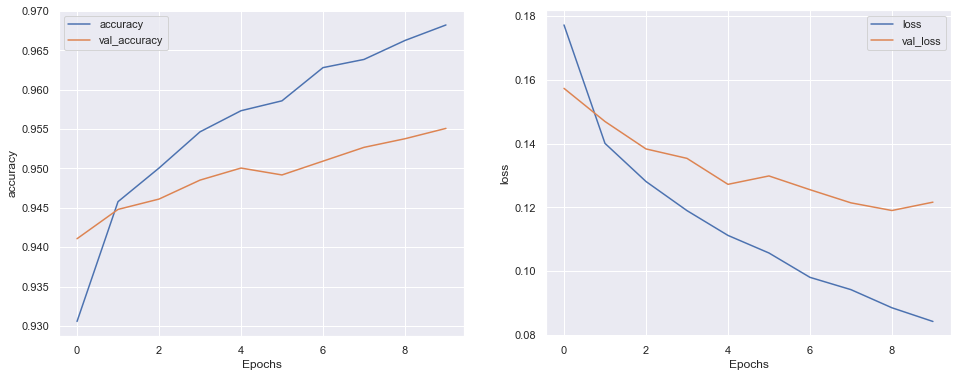

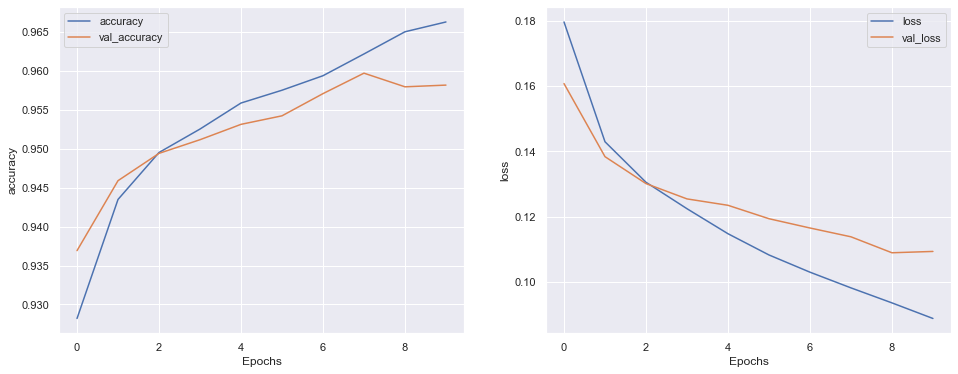

In [36]:
# Cross validation on model0
vals = kfold.split(x_train_embed, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train_embed[train_i]
    x_train_val = x_train_embed[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    # Build model with 100 hidden layer
    model0 = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model0.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    # Fit model with training and validation data
    history = model0.fit(x_train_train, y_train_train,
                  epochs=10,
                  batch_size=10,
                  verbose=1,
                  validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model0.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

In [37]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10844401270151138 - Accuracy: 96.01314067840576%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.11684444546699524 - Accuracy: 95.64074277877808%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.12005196511745453 - Accuracy: 95.3997790813446%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.12165245413780212 - Accuracy: 95.50930857658386%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.10932441800832748 - Accuracy: 95.81599235534668%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 95.6757926940918% (+- 0.21844385086531085)
> Loss: 0.11526345908641815
----------------------

### Changing number of hidden units from 10 to 50 increases the accuracy, but no significant increasing from 50 to 100. Also, it has a side effect of overfitting. So we finally choose 50 hidden units.

In [38]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 1s 630us/step - loss: 0.1903 - accuracy: 0.9244 - val_loss: 0.1469 - val_accuracy: 0.9428
Epoch 2/10
1826/1826 [==============================] - 1s 584us/step - loss: 0.1503 - accuracy: 0.9407 - val_loss: 0.1415 - val_accuracy: 0.9437
Epoch 3/10
1826/1826 [==============================] - 1s 594us/step - loss: 0.1405 - accuracy: 0.9445 - val_loss: 0.1340 - val_accuracy: 0.9490
Epoch 4/10
1826/1826 [==============================] - 1s 586us/step - loss: 0.1321 - accuracy: 0.9480 - val_loss: 0.1312 - val_accuracy: 0.9496
Epoch 5/10
1826/1826 [==============================] - 1s 574us/step - loss: 0.1246 - accuracy: 0.9518 - val_loss: 0.1307 - val_accuracy: 0.9520
Epoch 6/10
1826/1826 [==============================] - 1s 548us/step - loss: 0.1202 - accuracy: 0.9532 - val_loss: 0.1223 - val_accuracy: 0.9518
Epoch 7/10
1826/1826 [=====

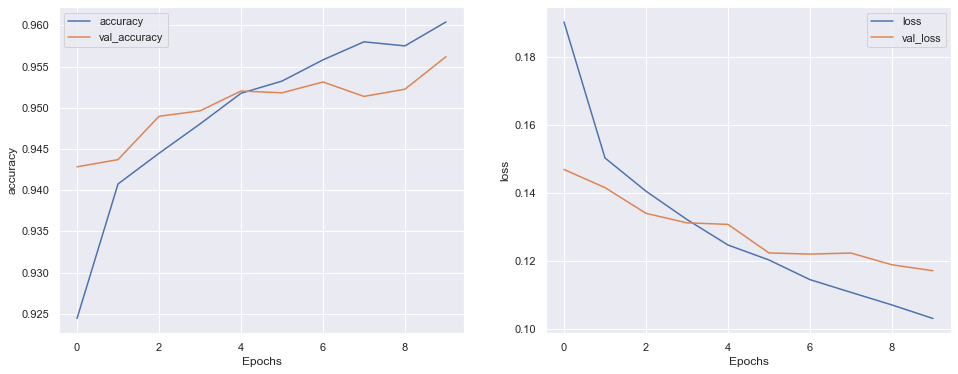

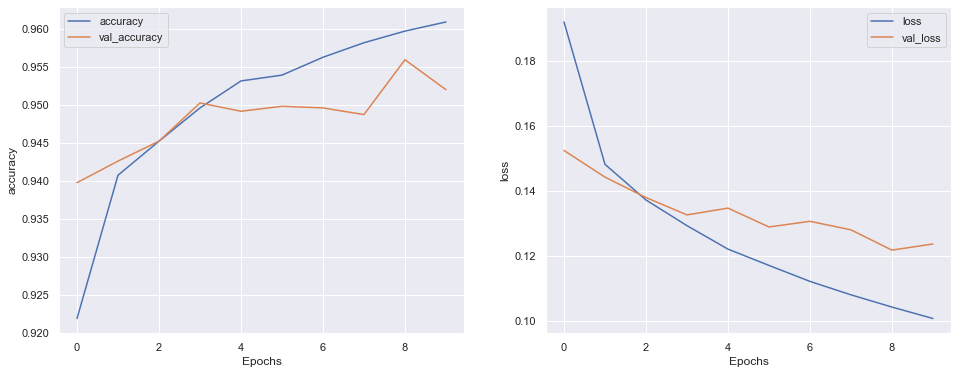

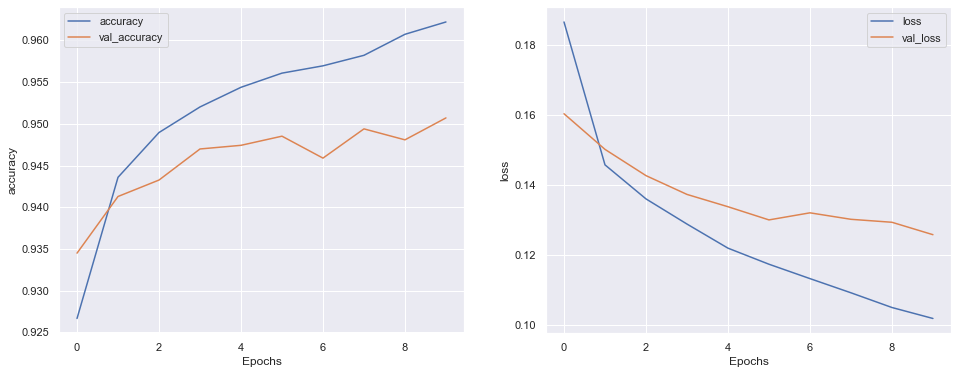

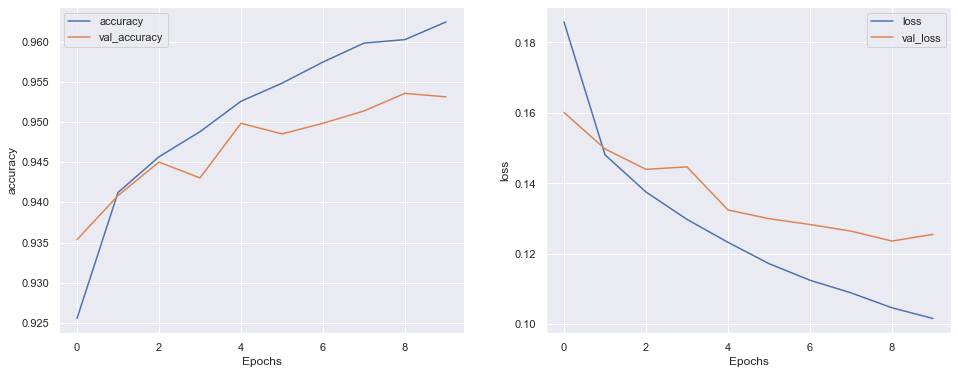

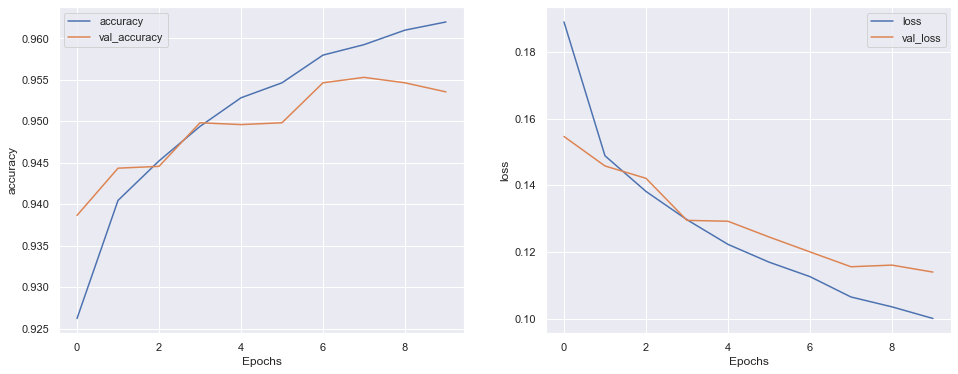

In [39]:
# Cross validation on model0
vals = kfold.split(x_train_embed, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train_embed[train_i]
    x_train_val = x_train_embed[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    # Build model with 50 hidden layer
    model0 = tf.keras.Sequential([
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model0.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    # Fit model with training and validation data
    history = model0.fit(x_train_train, y_train_train,
                  epochs=10,
                  batch_size=10,
                  verbose=1,
                  validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model0.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

### A little overfitting

In [40]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 1s 707us/step - loss: 0.2181 - accuracy: 0.9140 - val_loss: 0.1545 - val_accuracy: 0.9411
Epoch 2/10
1826/1826 [==============================] - 1s 562us/step - loss: 0.1662 - accuracy: 0.9344 - val_loss: 0.1436 - val_accuracy: 0.9435
Epoch 3/10
1826/1826 [==============================] - 1s 568us/step - loss: 0.1588 - accuracy: 0.9382 - val_loss: 0.1425 - val_accuracy: 0.9452
Epoch 4/10
1826/1826 [==============================] - 1s 632us/step - loss: 0.1513 - accuracy: 0.9427 - val_loss: 0.1380 - val_accuracy: 0.9496
Epoch 5/10
1826/1826 [==============================] - 1s 590us/step - loss: 0.1502 - accuracy: 0.9413 - val_loss: 0.1366 - val_accuracy: 0.9476
Epoch 6/10
1826/1826 [==============================] - 1s 595us/step - loss: 0.1458 - accuracy: 0.9446 - val_loss: 0.1328 - val_accuracy: 0.9509
Epoch 7/10
1826/1826 [=====

Epoch 8/10
1826/1826 [==============================] - 1s 627us/step - loss: 0.1364 - accuracy: 0.9491 - val_loss: 0.1305 - val_accuracy: 0.9538
Epoch 9/10
1826/1826 [==============================] - 1s 579us/step - loss: 0.1361 - accuracy: 0.9492 - val_loss: 0.1293 - val_accuracy: 0.9507
Epoch 10/10
143/143 [==============================] - 0s 415us/step - loss: 0.1285 - accuracy: 0.9525
Test Loss: 0.12852749228477478
Test Accuracy: 0.9524644017219543


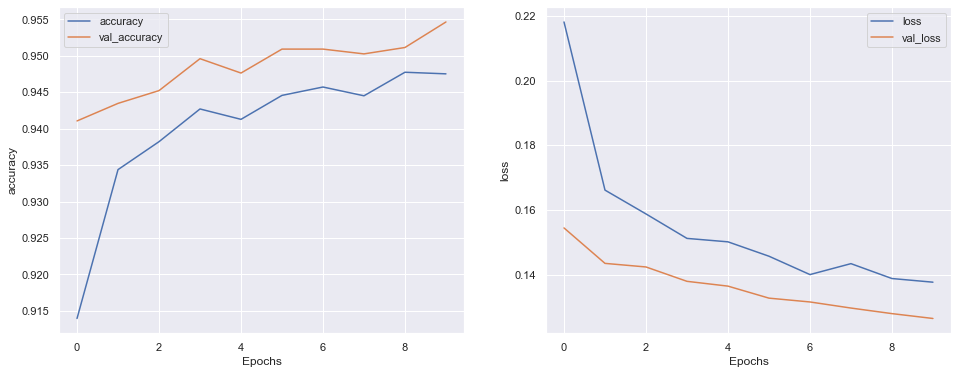

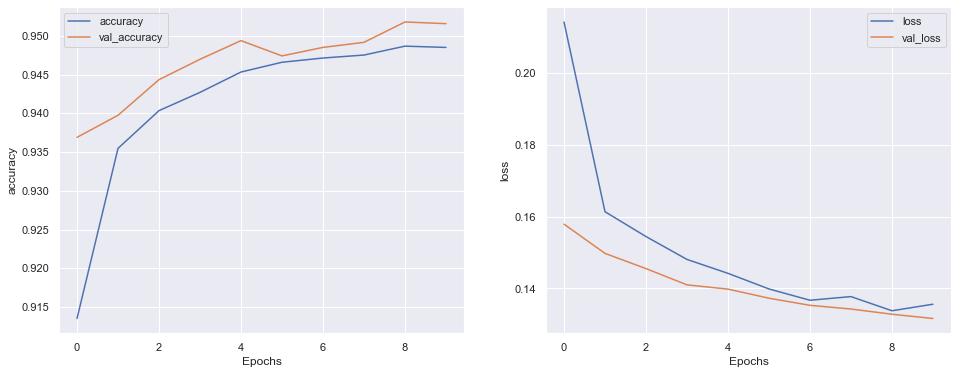

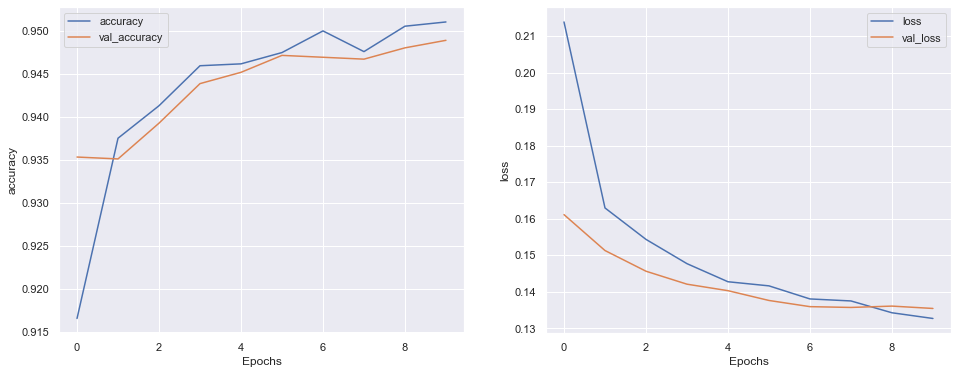

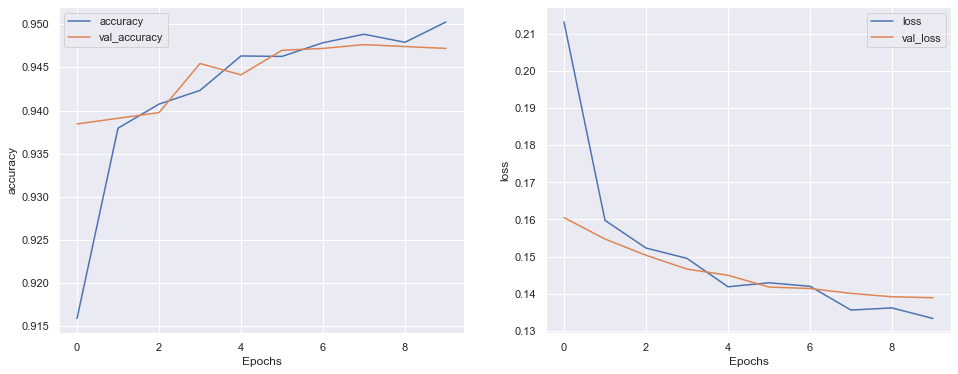

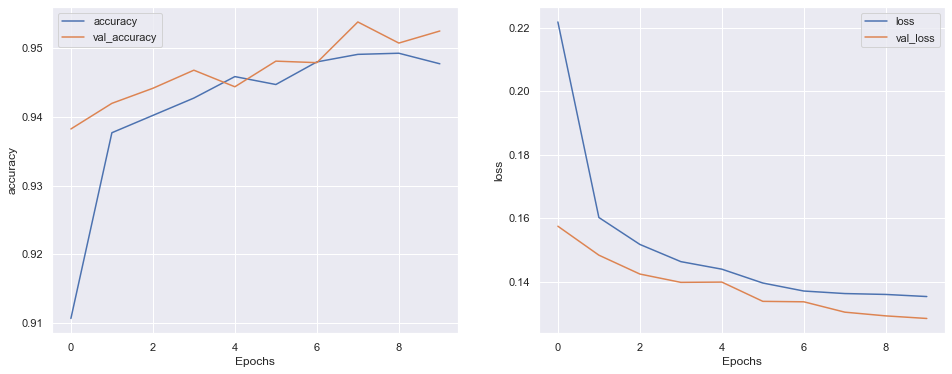

In [41]:
# Apply dropout to prevent overfitting.

vals = kfold.split(x_train_embed, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train_embed[train_i]
    x_train_val = x_train_embed[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    # Build model
    model0 = tf.keras.Sequential([
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model0.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    # Fit model with training and validation data
    history = model0.fit(x_train_train, y_train_train,
                  epochs=10,
                  batch_size=10,
                  verbose=1,
                  validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model0.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

### Looks good

In [42]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.12656427919864655 - Accuracy: 95.46549916267395%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.13163445889949799 - Accuracy: 95.15881538391113%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.13547328114509583 - Accuracy: 94.8959469795227%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.13888002932071686 - Accuracy: 94.72070336341858%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.12852749228477478 - Accuracy: 95.24644017219543%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 95.09748101234436% (+- 0.2622843718281517)
> Loss: 0.1322159081697464
-----------------------

In [43]:
# Predict
pred_labels = model0.predict(x_test_embed)
pred_labels[:10]

array([[9.9534082e-01],
       [9.9901569e-01],
       [3.6118396e-05],
       [2.4614424e-02],
       [9.0658665e-04],
       [1.2743384e-02],
       [9.9937445e-01],
       [1.0000000e+00],
       [5.9035182e-02],
       [1.0000000e+00]], dtype=float32)

In [44]:
# Decision boundary
pred_labels = np.where(pred_labels < 0.5, 0, pred_labels)
pred_labels = np.where(pred_labels >= 0.5, 1, pred_labels)
pred_labels = pred_labels.astype(int)
pred_labels[0:10]


array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1]])

In [45]:
# Convert the number labels back to strings
pred_labels = pred_labels.astype(str)
pred_labels = np.where(pred_labels == '0', 'python', pred_labels)
pred_labels = np.where(pred_labels == '1', 'nba', pred_labels)
pred_labels[0:10]

array([['nba'],
       ['nba'],
       ['python'],
       ['python'],
       ['python'],
       ['python'],
       ['nba'],
       ['nba'],
       ['python'],
       ['nba']], dtype='<U11')

In [46]:
y_test_array = np.array(y_test)
y_test_array[0:10]

array(['nba', 'nba', 'python', 'python', 'python', 'python', 'nba', 'nba',
       'python', 'nba'], dtype='<U6')

Text(84.453125, 0.5, 'predicted label')

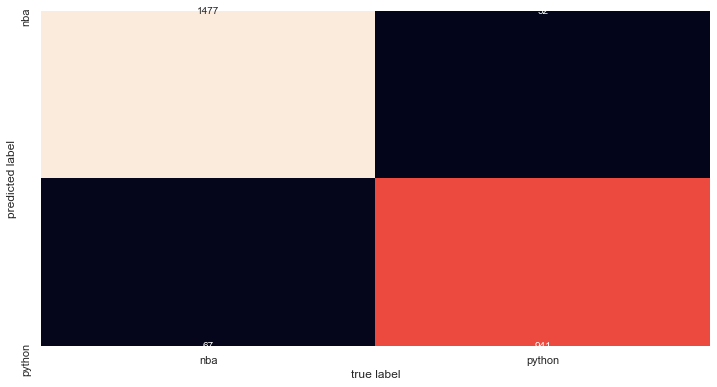

In [56]:
# Heatmap
mat = confusion_matrix(y_test_array, pred_labels)
plt.figure(figsize=(12,12))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test_array)), yticklabels=sorted(set(y_test_array)))
plt.xlabel('true label')
plt.ylabel('predicted label')


In [48]:
info = []

# F1 scores
print("Neural Network One hidden layer with 50 units:")
print("Microaveraged F1 scores:", f1_score(y_test_array, pred_labels, average='micro'))
info.append(f1_score(y_test_array, pred_labels, average='micro'))
print("Macroaveraged F1 scores", f1_score(y_test_array, pred_labels, average="macro"))
info.append(f1_score(y_test_array, pred_labels, average="macro"))

models_eval['Neural Network 1 Layer Tensorflow']=info

Neural Network One hidden layer with 50 units:
Microaveraged F1 scores: 0.9530942057548285
Macroaveraged F1 scores 0.9509026807780621


## 8.2 Model1: Neural Network multipal hidden layer with 50 units

In [49]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
1826/1826 [==============================] - 1s 781us/step - loss: 0.1714 - accuracy: 0.9321 - val_loss: 0.1429 - val_accuracy: 0.9406
Epoch 2/10
1826/1826 [==============================] - 1s 752us/step - loss: 0.1355 - accuracy: 0.9477 - val_loss: 0.1273 - val_accuracy: 0.9527
Epoch 3/10
1826/1826 [==============================] - 1s 734us/step - loss: 0.1204 - accuracy: 0.9524 - val_loss: 0.1282 - val_accuracy: 0.9540
Epoch 4/10
1826/1826 [==============================] - 1s 751us/step - loss: 0.1087 - accuracy: 0.9595 - val_loss: 0.1217 - val_accuracy: 0.9555
Epoch 5/10
1826/1826 [==============================] - 1s 730us/step - loss: 0.1000 - accuracy: 0.9620 - val_loss: 0.1147 - val_accuracy: 0.9582
Epoch 6/10
1826/1826 [==============================] - 1s 760us/step - loss: 0.0916 - accuracy: 0.9656 - val_loss: 0.1167 - val_accuracy: 0.9582
Epoch 7/10
1826/1826 [=====

Epoch 8/10
1826/1826 [==============================] - 1s 640us/step - loss: 0.0773 - accuracy: 0.9705 - val_loss: 0.1288 - val_accuracy: 0.9560
Epoch 9/10
1826/1826 [==============================] - 1s 603us/step - loss: 0.0701 - accuracy: 0.9738 - val_loss: 0.1238 - val_accuracy: 0.9553
Epoch 10/10
143/143 [==============================] - 0s 401us/step - loss: 0.1285 - accuracy: 0.9525
Test Loss: 0.12852749228477478
Test Accuracy: 0.9524644017219543


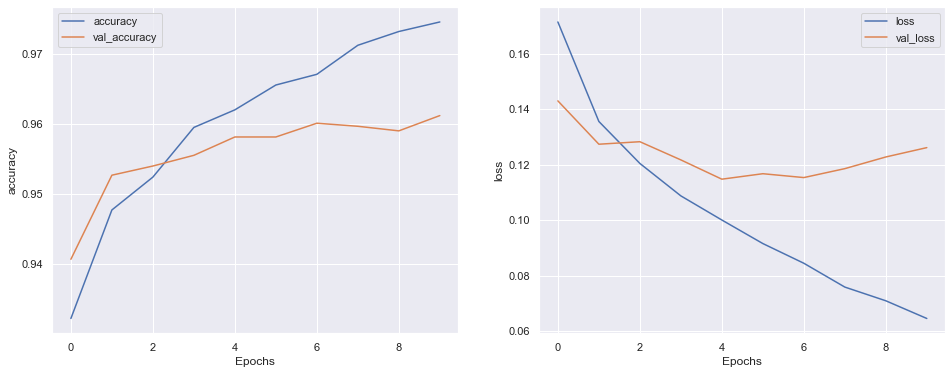

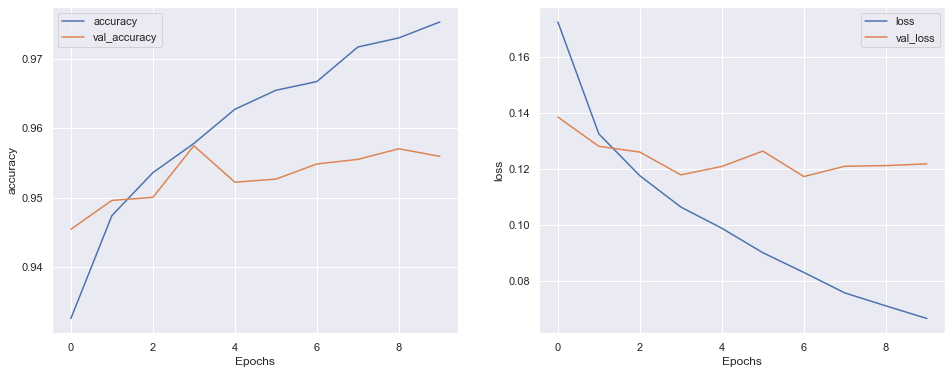

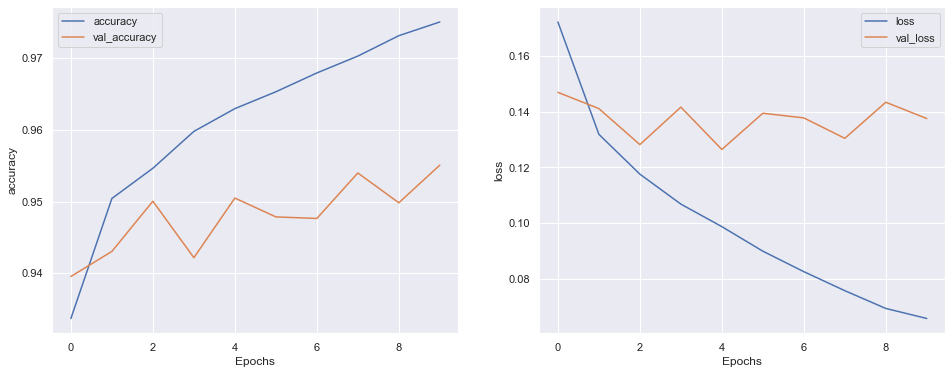

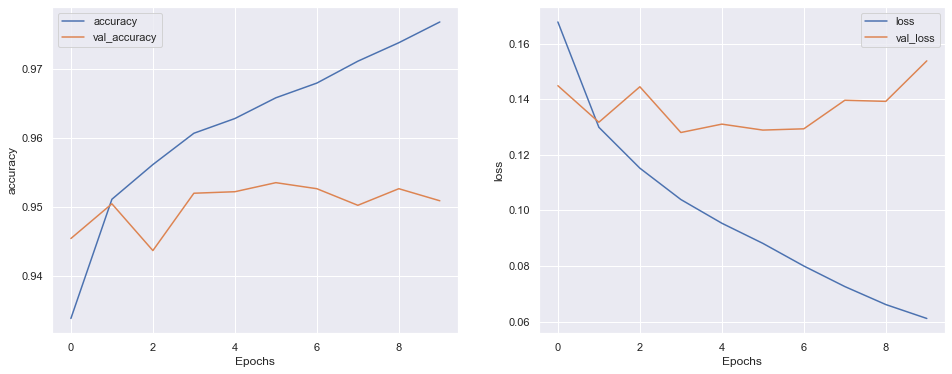

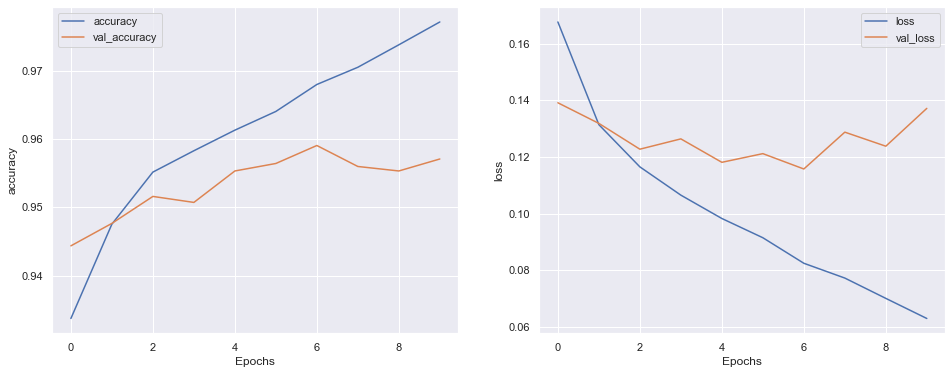

In [57]:
# Cross validation on model1

vals = kfold.split(x_train_embed, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train_embed[train_i]
    x_train_val = x_train_embed[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    # Build model with 3 hidden layers
    model1 = tf.keras.Sequential([
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model1.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    # Fit model with training and validation data
    history = model1.fit( x_train_train, y_train_train,
                  epochs=10,
                  batch_size=10,
                  verbose=1,
                  validation_data = (x_train_val,y_train_val))

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model0.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1




In [58]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.11141636222600937 - Accuracy: 95.9474265575409%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.11141636222600937 - Accuracy: 95.9474265575409%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.11698844283819199 - Accuracy: 95.88170647621155%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.116424061357975 - Accuracy: 95.55312395095825%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.11832009255886078 - Accuracy: 95.55312395095825%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.12852749228477478 - Accuracy: 95.24644017219543%
----------------------------------------------------------------------

### Increasing layers does not significantly change the predicton accuracy(only change train accuracy).

### Above is overfitting

In [59]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 1s 818us/step - loss: 0.2132 - accuracy: 0.9115 - val_loss: 0.1378 - val_accuracy: 0.9459
Epoch 2/10
1826/1826 [==============================] - 1s 761us/step - loss: 0.1601 - accuracy: 0.9380 - val_loss: 0.1335 - val_accuracy: 0.9507
Epoch 3/10
1826/1826 [==============================] - 1s 786us/step - loss: 0.1515 - accuracy: 0.9405 - val_loss: 0.1294 - val_accuracy: 0.9485
Epoch 4/10
1826/1826 [==============================] - 1s 705us/step - loss: 0.1487 - accuracy: 0.9425 - val_loss: 0.1273 - val_accuracy: 0.9507
Epoch 5/10
1826/1826 [==============================] - 1s 757us/step - loss: 0.1398 - accuracy: 0.9450 - val_loss: 0.1380 - val_accuracy: 0.9518
Epoch 6/10
1826/1826 [==============================] - 1s 779us/step - loss: 0.1334 - accuracy: 0.9499 - val_loss: 0.1211 - val_accuracy: 0.9549
Epoch 7/10
1826/1826 [=====

Epoch 6/10
1826/1826 [==============================] - 1s 769us/step - loss: 0.1343 - accuracy: 0.9481 - val_loss: 0.1292 - val_accuracy: 0.9494
Epoch 7/10
1826/1826 [==============================] - 1s 782us/step - loss: 0.1326 - accuracy: 0.9474 - val_loss: 0.1273 - val_accuracy: 0.9507
Epoch 8/10
1826/1826 [==============================] - 1s 653us/step - loss: 0.1309 - accuracy: 0.9496 - val_loss: 0.1246 - val_accuracy: 0.9531
Epoch 9/10
1826/1826 [==============================] - 1s 664us/step - loss: 0.1246 - accuracy: 0.9510 - val_loss: 0.1261 - val_accuracy: 0.9505
Epoch 10/10
143/143 [==============================] - 0s 411us/step - loss: 0.1285 - accuracy: 0.9525
Test Loss: 0.12852749228477478
Test Accuracy: 0.9524644017219543


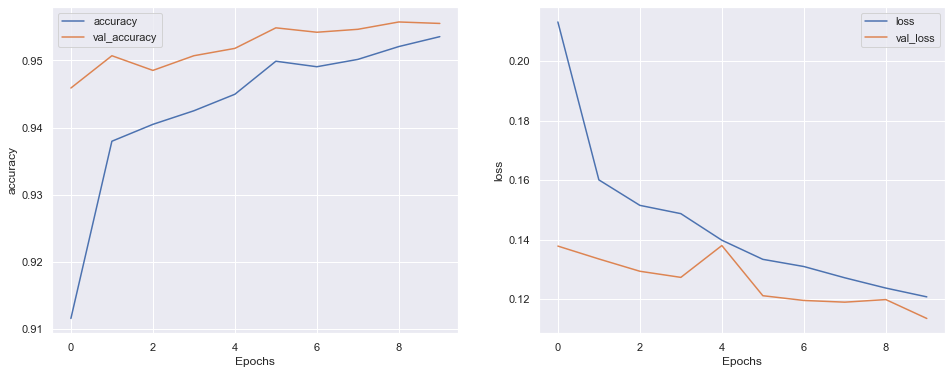

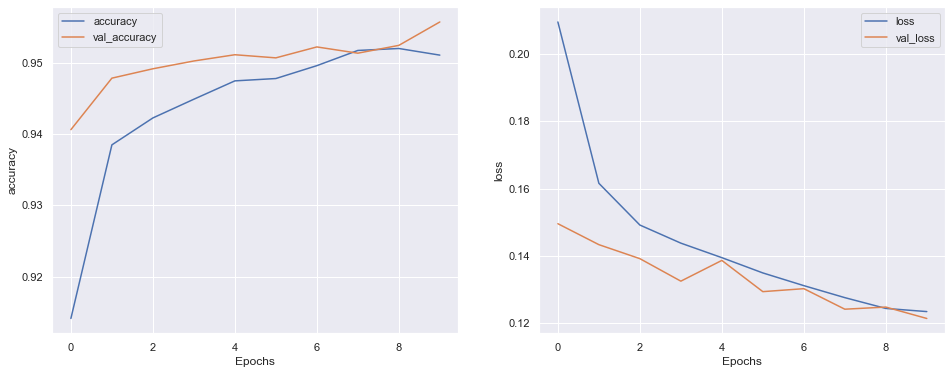

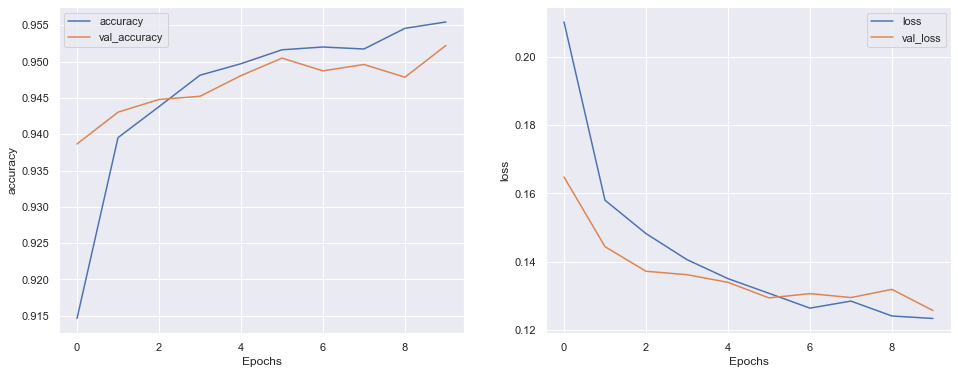

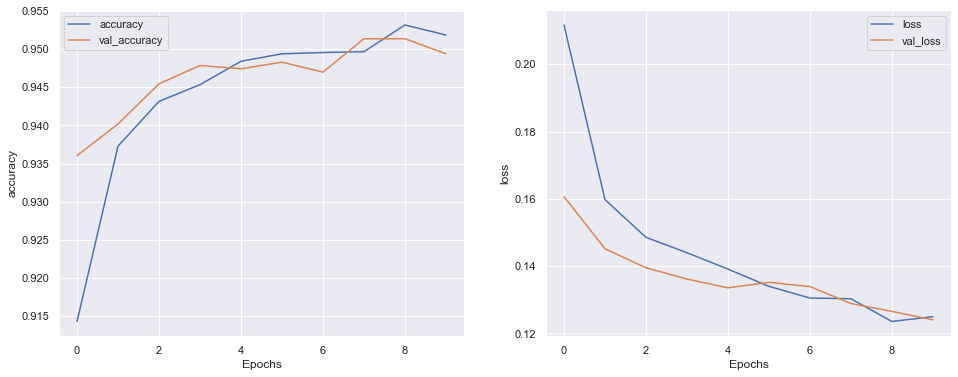

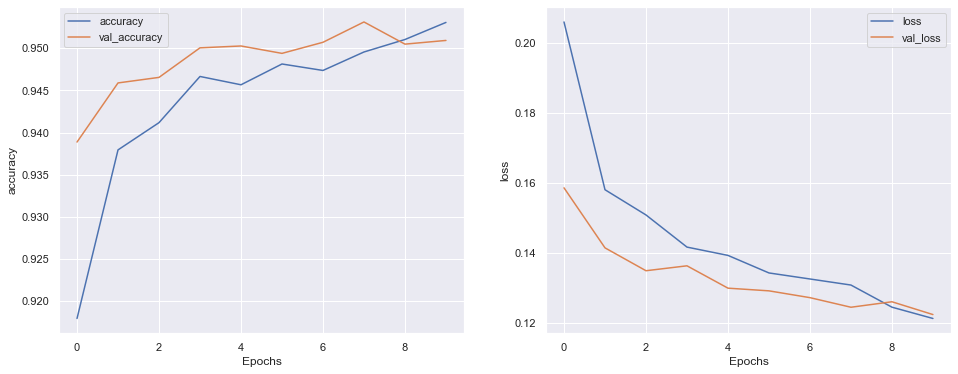

In [60]:
# Apply dropout to prevent overfitting.

vals = kfold.split(x_train_embed, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train_embed[train_i]
    x_train_val = x_train_embed[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    
    model1 = tf.keras.Sequential([
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model1.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    # Fit model with training and validation data
    history = model1.fit(x_train_train, y_train_train,
                  epochs=10,
                  batch_size=10,
                  verbose=1,
                  validation_data = (x_train_val,y_train_val))

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model0.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1


### Good

In [61]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.11141636222600937 - Accuracy: 95.9474265575409%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.11698844283819199 - Accuracy: 95.88170647621155%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.116424061357975 - Accuracy: 95.55312395095825%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.11832009255886078 - Accuracy: 95.55312395095825%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.12852749228477478 - Accuracy: 95.24644017219543%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 95.63636422157288% (+- 0.2541067682514418)
> Loss: 0.11833529025316239
------------------------

In [62]:
# Predict
pred_labels = model1.predict(x_test_embed)
pred_labels[:10]

array([[9.9543011e-01],
       [9.9949706e-01],
       [7.7581406e-04],
       [1.1619568e-02],
       [4.4621825e-03],
       [1.6451836e-02],
       [9.9909508e-01],
       [1.0000000e+00],
       [3.4958571e-02],
       [1.0000000e+00]], dtype=float32)

In [63]:
# Decision boundary
pred_labels = np.where(pred_labels < 0.5, 0, pred_labels)
pred_labels = np.where(pred_labels >= 0.5, 1, pred_labels)
pred_labels = pred_labels.astype(int)
pred_labels[0:10]


array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1]])

In [64]:
# Convert the number labels back to strings
pred_labels = pred_labels.astype(str)
pred_labels = np.where(pred_labels == '0', 'python', pred_labels)
pred_labels = np.where(pred_labels == '1', 'nba', pred_labels)
pred_labels[0:10]

array([['nba'],
       ['nba'],
       ['python'],
       ['python'],
       ['python'],
       ['python'],
       ['nba'],
       ['nba'],
       ['python'],
       ['nba']], dtype='<U11')

In [65]:
y_test_array = np.array(y_test)
y_test_array[0:10]

array(['nba', 'nba', 'python', 'python', 'python', 'python', 'nba', 'nba',
       'python', 'nba'], dtype='<U6')

Text(84.453125, 0.5, 'predicted label')

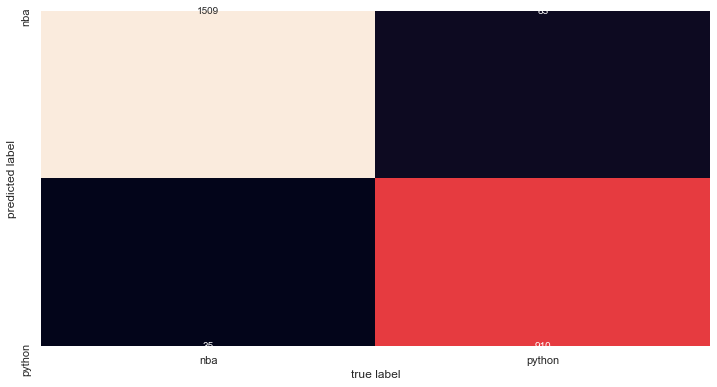

In [66]:
# Heatmap
mat = confusion_matrix(y_test_array, pred_labels)
plt.figure(figsize=(12,12))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test_array)), yticklabels=sorted(set(y_test_array)))
plt.xlabel('true label')
plt.ylabel('predicted label')

In [67]:
info = []

# F1 scores
print("Neural Network Three hidden layer with 50 units:")
print("Microaveraged F1 scores:", f1_score(y_test_array, pred_labels, average='micro'))
info.append(f1_score(y_test_array, pred_labels, average='micro'))
print("Macroaveraged F1 scores", f1_score(y_test_array, pred_labels, average="macro"))
info.append(f1_score(y_test_array, pred_labels, average="macro"))

models_eval['Neural Network 3 Layer Tensorflow']=info

Neural Network Three hidden layer with 50 units:
Microaveraged F1 scores: 0.9534883720930233
Macroaveraged F1 scores 0.9507424680398475


## 8.3 Recurrent Neural Network

### 8.3.1 Word Encoding

In [68]:
# Build word encoderv with vocabulary size = 1000

VOCAB_SIZE=1000

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(x_train)

In [69]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'draft', 'to', 'a', 'in', 'and', 'for', 'of',
       'is', 'with', 'on', 'i', 'you', 'pick', 'this', 'are', 'be', 'it'],
      dtype='<U22')

In [70]:
# Showing encoded data
encoded_x_train_a = encoder(x_train).numpy()
encoded_x_train_a

array([[  5,   1,   4, ...,   0,   0,   0],
       [331,  57, 100, ...,   0,   0,   0],
       [  2,  10, 156, ...,   0,   0,   0],
       ...,
       [381, 139,   1, ...,   0,   0,   0],
       [  1,  10,   1, ...,   0,   0,   0],
       [  1,   6, 523, ...,   0,   0,   0]], dtype=int64)

In [71]:
# Showing encoded data
encoded_x_test_a = encoder(x_test).numpy()
encoded_x_test_a

array([[ 30, 175, 204, ...,   0,   0,   0],
       [211,   1,   7, ...,   0,   0,   0],
       [  1,  10,   1, ...,   0,   0,   0],
       ...,
       [688, 885,  81, ...,   0,   0,   0],
       [  2,  76,  64, ...,   0,   0,   0],
       [142,  17, 305, ...,   0,   0,   0]], dtype=int64)

### 8.3.2 Model2: Long Short-Term Memory

#### 10 hidden units, 1 layer

In [72]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.1672 - accuracy: 0.9328 - val_loss: 0.0781 - val_accuracy: 0.9704
Epoch 2/10
1826/1826 [==============================] - 12s 7ms/step - loss: 0.0711 - accuracy: 0.9722 - val_loss: 0.0771 - val_accuracy: 0.9696
Epoch 3/10
1826/1826 [==============================] - 13s 7ms/step - loss: 0.0617 - accuracy: 0.9745 - val_loss: 0.0762 - val_accuracy: 0.9706
Epoch 4/10
1826/1826 [==============================] - 13s 7ms/step - loss: 0.0550 - accuracy: 0.9777 - val_loss: 0.0729 - val_accuracy: 0.9691
Epoch 5/10
1826/1826 [==============================] - 13s 7ms/step - loss: 0.0504 - accuracy: 0.9796 - val_loss: 0.0849 - val_accuracy: 0.9696
Epoch 6/10
1826/1826 [==============================] - 12s 7ms/step - loss: 0.0466 - accuracy: 0.9814 - val_loss: 0.0811 - val_accuracy: 0.9689
Epoch 7/10
1826/1826 [===========

Epoch 10/10
143/143 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.9735
Test Loss: 0.07966576516628265
Test Accuracy: 0.9734939932823181


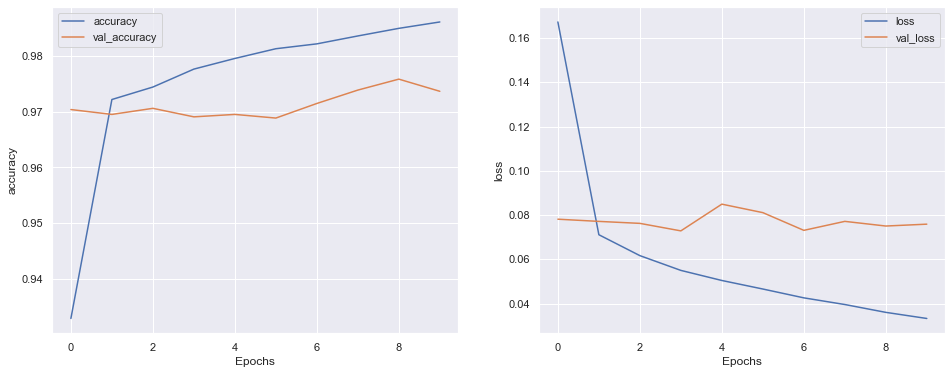

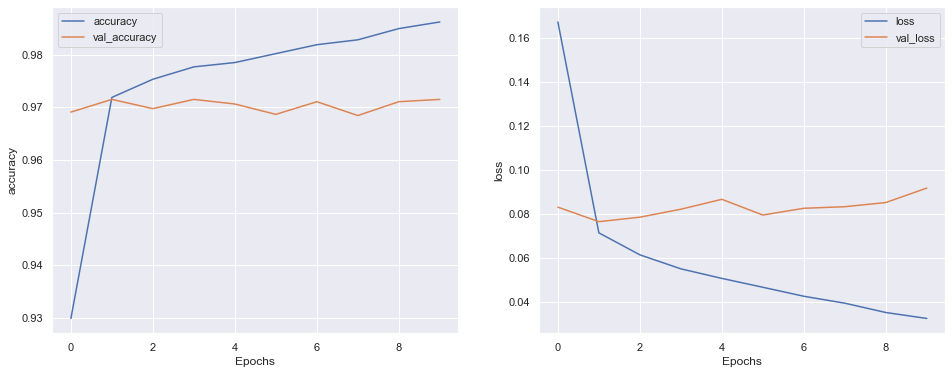

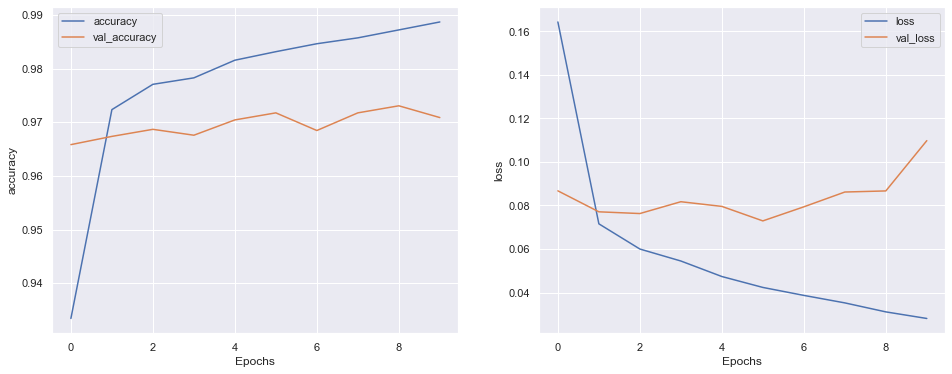

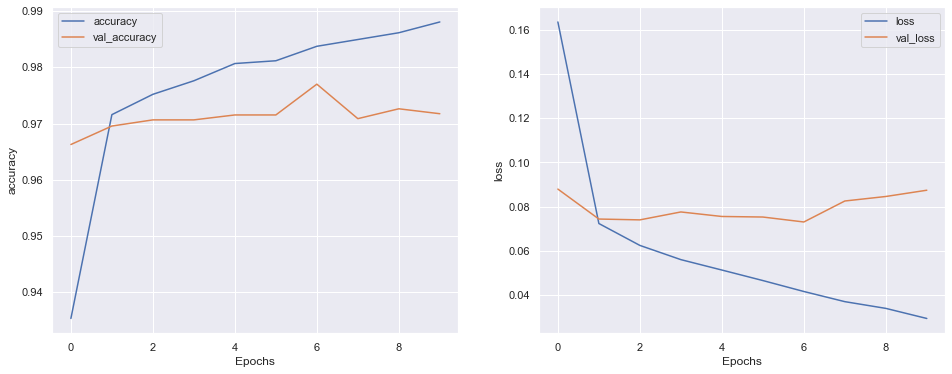

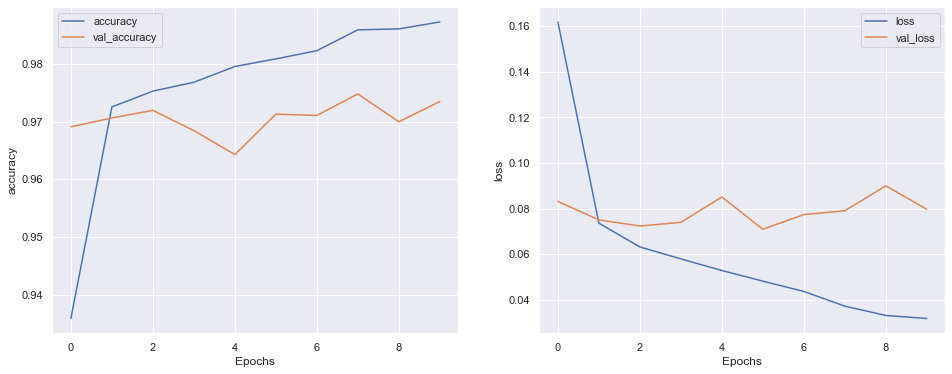

In [73]:
# Cross validation split the training data
vals = kfold.split(x_train, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train[train_i]
    x_train_val = x_train[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    # Build model with one LSTM with 1 layer and 10 hidden units
    model2 = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=10,
            mask_zero=True),
        tf.keras.layers.LSTM(10),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')

    # Fit model with validation data
    history = model2.fit(x_train_train,y_train_train,
                         epochs=10,
                         batch_size=10,
                         verbose=1,
                         validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    # Evaluate the model with validation data and store it.
    test_loss, test_acc = model2.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

In [74]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.07588569074869156 - Accuracy: 97.37130403518677%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.09191039949655533 - Accuracy: 97.15224504470825%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.10980389267206192 - Accuracy: 97.0865249633789%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.08746598660945892 - Accuracy: 97.17414975166321%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.07966576516628265 - Accuracy: 97.34939932823181%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.22672462463379% (+- 0.11306596213578203)
> Loss: 0.08894634693861007
---------------------

### The accuracy improves a lot compare to simple neural network.

#### 50 hidden units, 1 layer

In [75]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 17s 9ms/step - loss: 0.1296 - accuracy: 0.9452 - val_loss: 0.0761 - val_accuracy: 0.9726
Epoch 2/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0716 - accuracy: 0.9697 - val_loss: 0.0784 - val_accuracy: 0.9623
Epoch 3/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0598 - accuracy: 0.9761 - val_loss: 0.0721 - val_accuracy: 0.9715
Epoch 4/10
1826/1826 [==============================] - 14s 8ms/step - loss: 0.0522 - accuracy: 0.9795 - val_loss: 0.0699 - val_accuracy: 0.9713
Epoch 5/10
1826/1826 [==============================] - 14s 8ms/step - loss: 0.0442 - accuracy: 0.9815 - val_loss: 0.0729 - val_accuracy: 0.9715
Epoch 6/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0371 - accuracy: 0.9846 - val_loss: 0.0837 - val_accuracy: 0.9696
Epoch 7/10
1826/1826 [===========

Epoch 10/10
143/143 [==============================] - 0s 3ms/step - loss: 0.1126 - accuracy: 0.9728
Test Loss: 0.11264675110578537
Test Accuracy: 0.9728367924690247


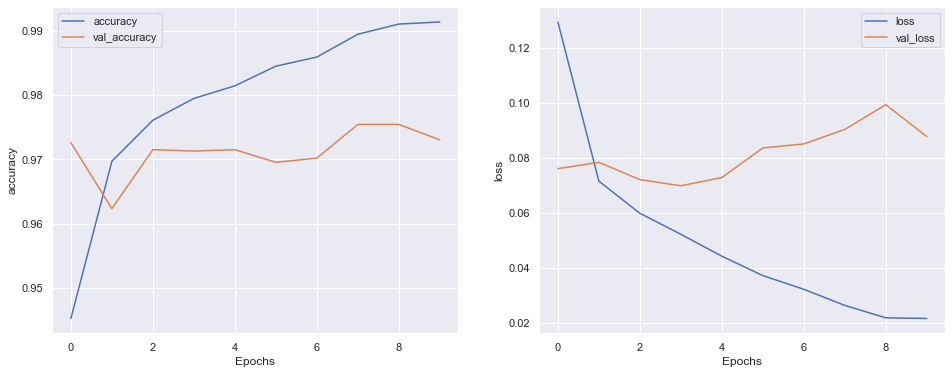

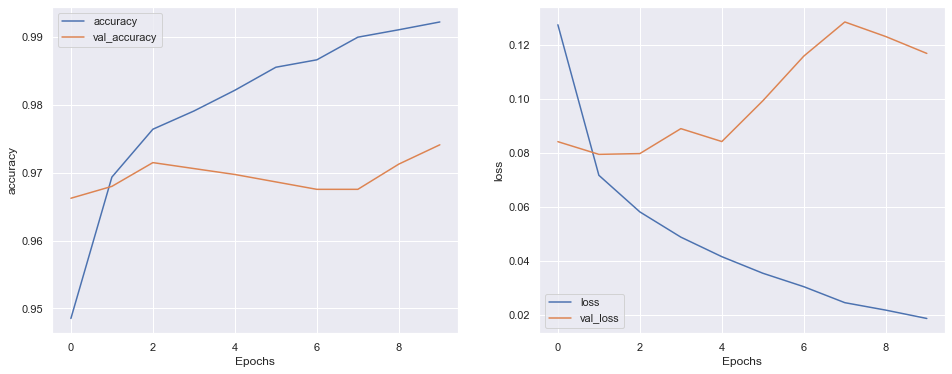

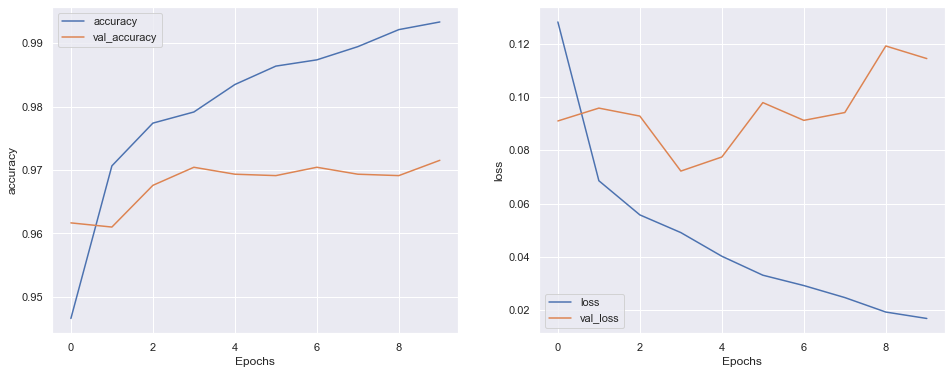

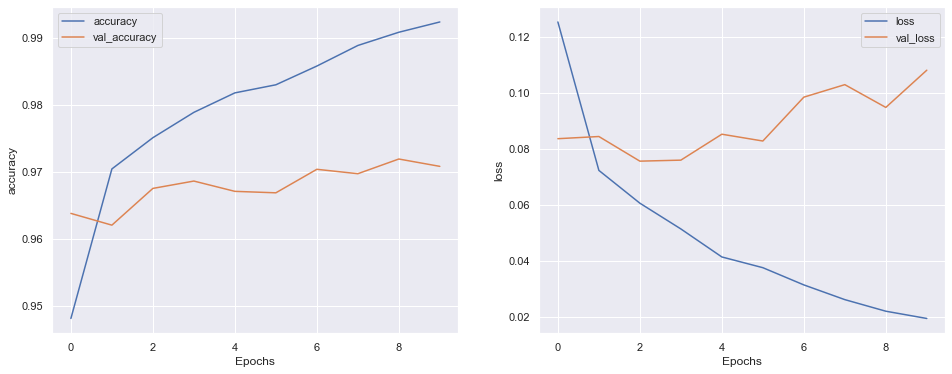

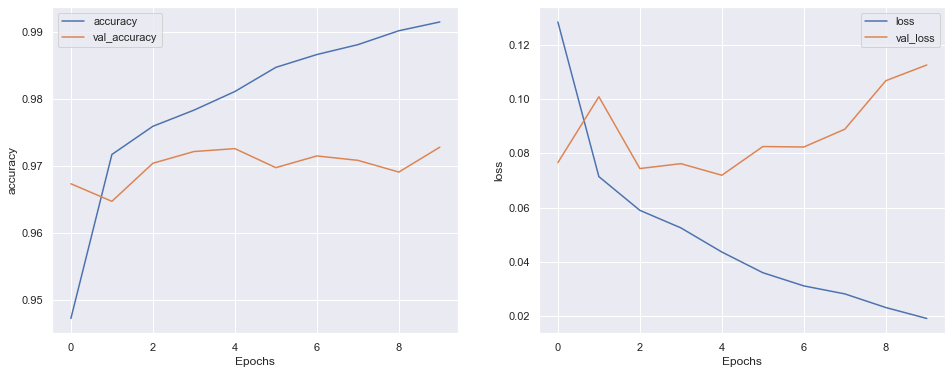

In [76]:
# Cross validation split the training data
vals = kfold.split(x_train, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train[train_i]
    x_train_val = x_train[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    # Build model with one LSTM with 1 layer and 50 hidden units
    model2 = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=50,
            mask_zero=True),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')

    # Fit model with validation data
    history = model2.fit(x_train_train,y_train_train,
                         epochs=10,
                         batch_size=10,
                         verbose=1,
                         validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    # Evaluate the model with validation data and store it.
    test_loss, test_acc = model2.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

In [77]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.08779400587081909 - Accuracy: 97.30558395385742%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.11694083362817764 - Accuracy: 97.41511344909668%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.11442989856004715 - Accuracy: 97.15224504470825%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.10811526328325272 - Accuracy: 97.0865249633789%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.11264675110578537 - Accuracy: 97.28367924690247%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.24862933158875% (+- 0.11641051833389854)
> Loss: 0.1079853504896164
----------------------

### Increasing hidden units does not improve predict accuracy (It only increasing the train accuracy). So we just choose 50 hidden units.

#### 50 units, 3 layers.

In [78]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 14s 8ms/step - loss: 0.1279 - accuracy: 0.9451 - val_loss: 0.0760 - val_accuracy: 0.9678
Epoch 2/10
1826/1826 [==============================] - 14s 8ms/step - loss: 0.0699 - accuracy: 0.9719 - val_loss: 0.0825 - val_accuracy: 0.9628
Epoch 3/10
1826/1826 [==============================] - 14s 8ms/step - loss: 0.0576 - accuracy: 0.9749 - val_loss: 0.0789 - val_accuracy: 0.9691
Epoch 4/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0470 - accuracy: 0.9785 - val_loss: 0.0887 - val_accuracy: 0.9689
Epoch 5/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0416 - accuracy: 0.9818 - val_loss: 0.0766 - val_accuracy: 0.9735
Epoch 6/10
1826/1826 [==============================] - 14s 8ms/step - loss: 0.0344 - accuracy: 0.9859 - val_loss: 0.0819 - val_accuracy: 0.9698
Epoch 7/10
1826/1826 [===========

Epoch 10/10
143/143 [==============================] - 0s 3ms/step - loss: 0.1391 - accuracy: 0.9706
Test Loss: 0.13911646604537964
Test Accuracy: 0.9706462025642395


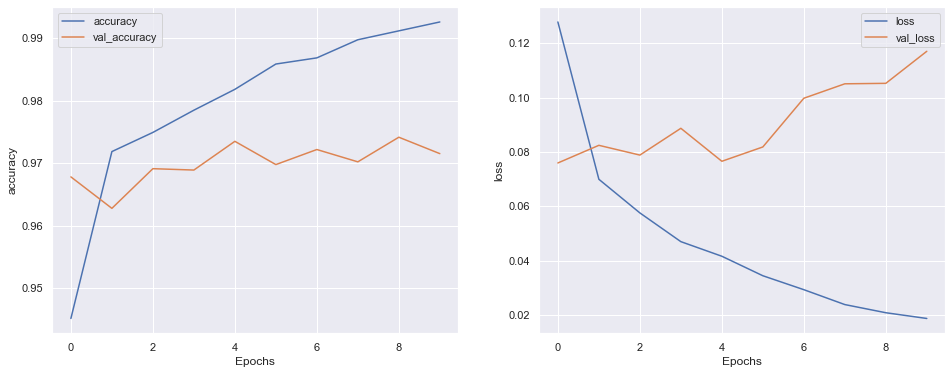

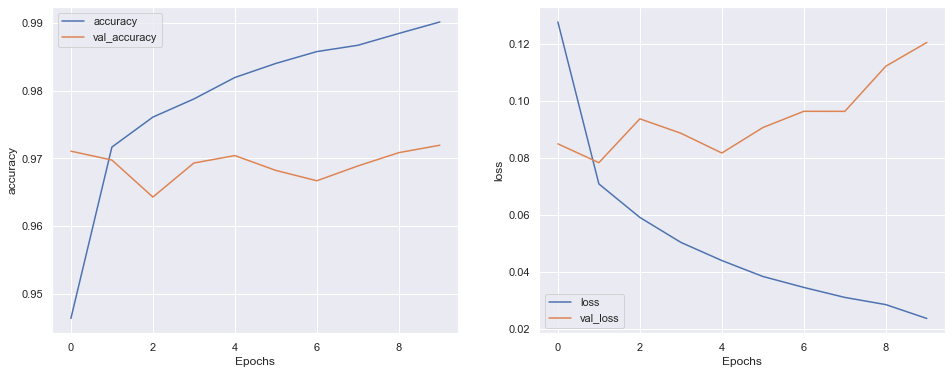

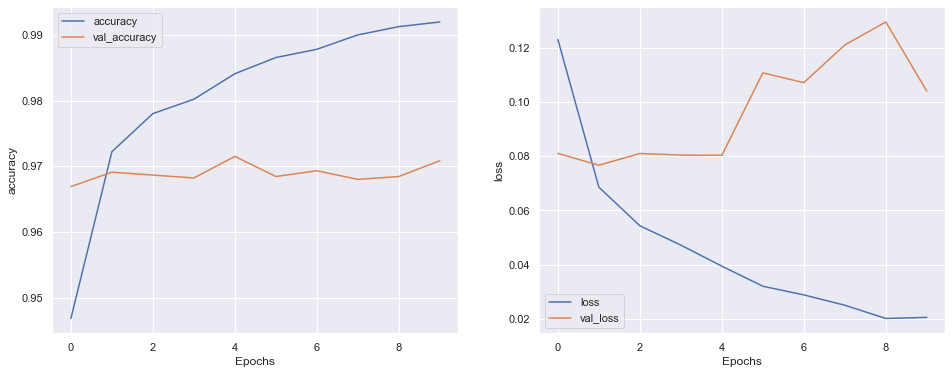

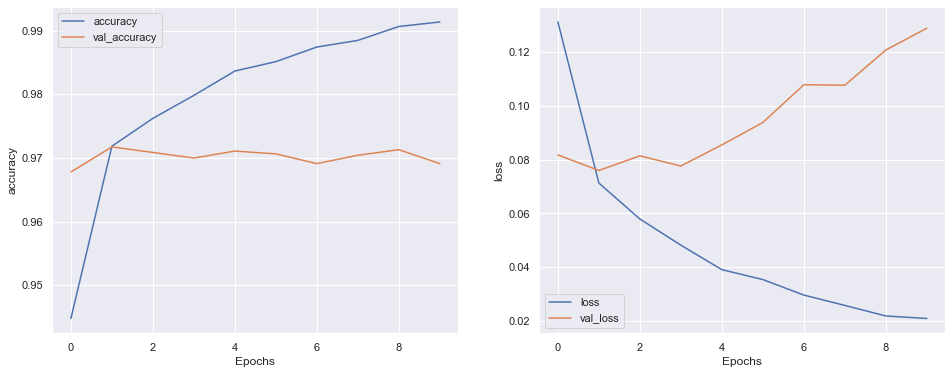

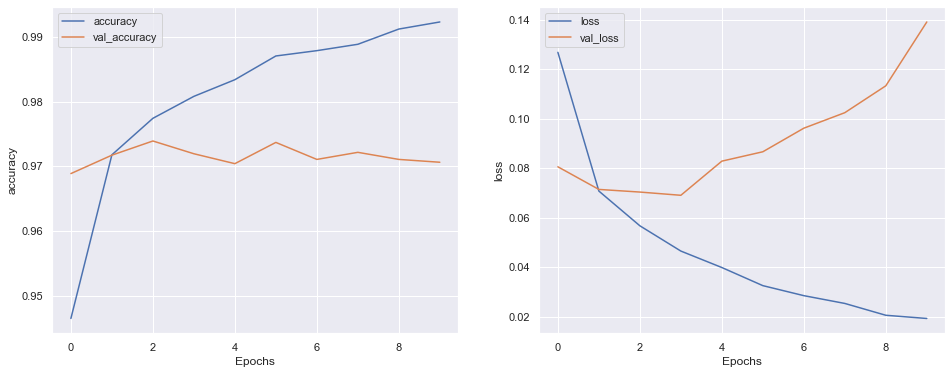

In [79]:
# Cross validation split the training data
vals = kfold.split(x_train, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train[train_i]
    x_train_val = x_train[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    inputShp = x_train_train.shape[0]
    
    # Build model with one LSTM with 3 layer and 50 hidden units
    model2 = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')

    # Fit model with validation data
    history = model2.fit(x_train_train,y_train_train,
                         epochs=10,
                         batch_size=10,
                         verbose=1,
                         validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    # Evaluate the model with validation data and store it.
    test_loss, test_acc = model2.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

In [80]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.11710809171199799 - Accuracy: 97.15224504470825%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.1204833835363388 - Accuracy: 97.19605445861816%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.10400962084531784 - Accuracy: 97.0865249633789%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.12891682982444763 - Accuracy: 96.91128134727478%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.13911646604537964 - Accuracy: 97.06462025642395%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.08214521408081% (+- 0.0973756330606013)
> Loss: 0.12192687839269638
-----------------------

### Adding layers does not improve accuracy. So finally we choose 50 hidden units, 1 layer.

In [81]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 17s 9ms/step - loss: 0.1265 - accuracy: 0.9462 - val_loss: 0.0834 - val_accuracy: 0.9691
Epoch 2/10
1826/1826 [==============================] - 16s 8ms/step - loss: 0.0704 - accuracy: 0.9706 - val_loss: 0.0808 - val_accuracy: 0.9693
Epoch 3/10
1826/1826 [==============================] - 16s 8ms/step - loss: 0.0578 - accuracy: 0.9767 - val_loss: 0.0762 - val_accuracy: 0.9700
Epoch 4/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0507 - accuracy: 0.9791 - val_loss: 0.0858 - val_accuracy: 0.9667
Epoch 5/10
1826/1826 [==============================] - 16s 9ms/step - loss: 0.0439 - accuracy: 0.9814 - val_loss: 0.0778 - val_accuracy: 0.9700
Epoch 6/10
1826/1826 [==============================] - 16s 9ms/step - loss: 0.0383 - accuracy: 0.9842 - val_loss: 0.0865 - val_accuracy: 0.9722
Epoch 7/10
1826/1826 [===========

Epoch 10/10
143/143 [==============================] - 1s 4ms/step - loss: 0.0989 - accuracy: 0.9757
Test Loss: 0.09890522807836533
Test Accuracy: 0.9756845831871033


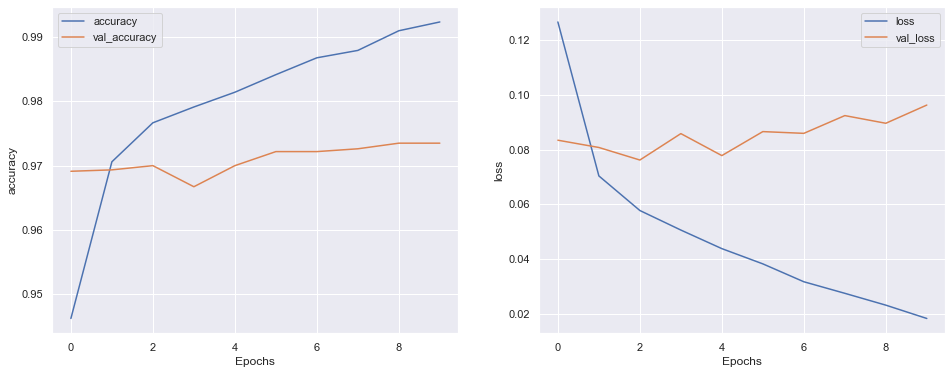

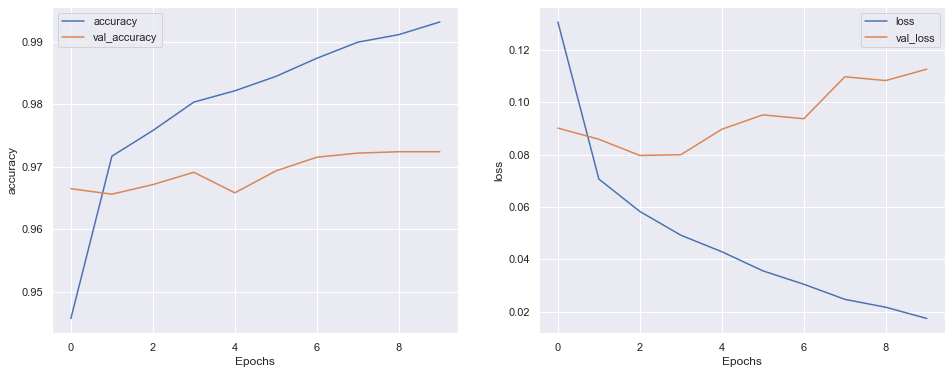

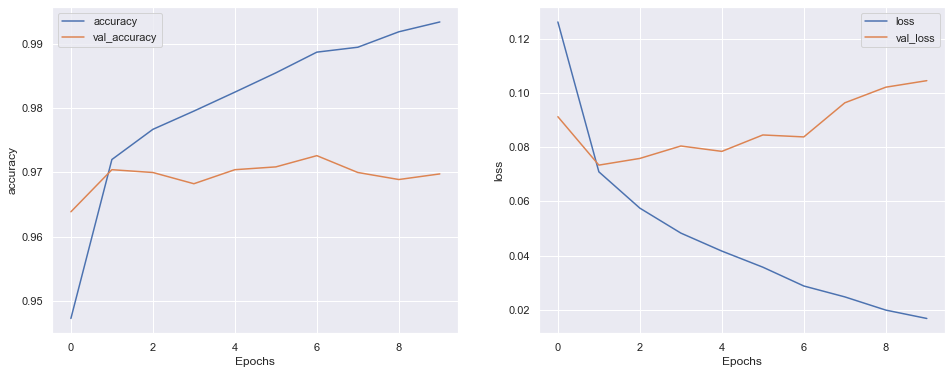

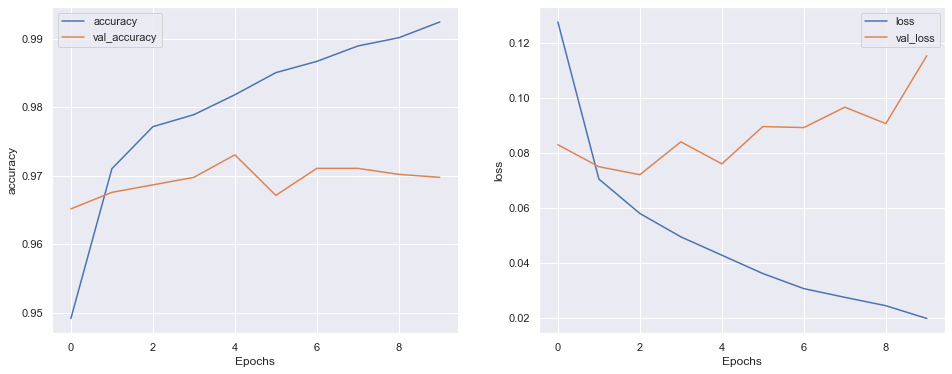

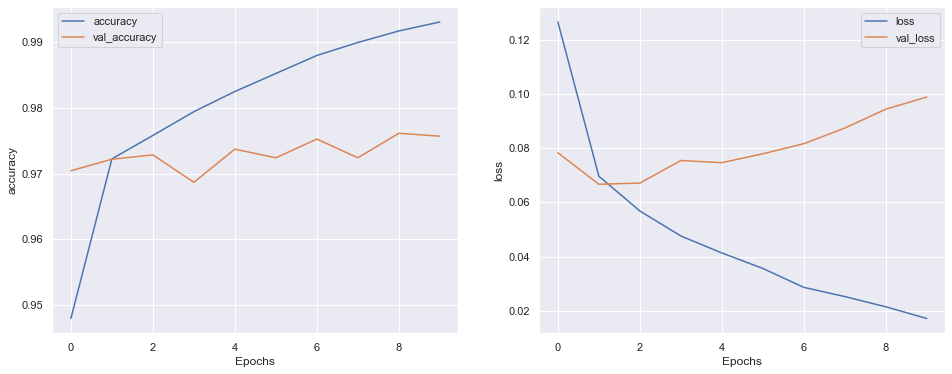

In [82]:
#

vals = kfold.split(x_train, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train[train_i]
    x_train_val = x_train[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    

    model2 = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=50,
            mask_zero=True),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    history = model2.fit(x_train_train,y_train_train,
                         epochs=10,
                         batch_size=10,
                         verbose=1,
                         validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model2.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

### Above is overfitting

In [83]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 18s 10ms/step - loss: 0.1585 - accuracy: 0.9367 - val_loss: 0.0831 - val_accuracy: 0.9650
Epoch 2/10
1826/1826 [==============================] - 16s 9ms/step - loss: 0.0796 - accuracy: 0.9682 - val_loss: 0.0770 - val_accuracy: 0.9706
Epoch 3/10
1826/1826 [==============================] - 16s 9ms/step - loss: 0.0701 - accuracy: 0.9721 - val_loss: 0.0821 - val_accuracy: 0.9693
Epoch 4/10
1826/1826 [==============================] - 16s 9ms/step - loss: 0.0645 - accuracy: 0.9744 - val_loss: 0.0739 - val_accuracy: 0.9706
Epoch 5/10
1826/1826 [==============================] - 16s 9ms/step - loss: 0.0592 - accuracy: 0.9760 - val_loss: 0.0758 - val_accuracy: 0.9722
Epoch 6/10
1826/1826 [==============================] - 16s 8ms/step - loss: 0.0553 - accuracy: 0.9773 - val_loss: 0.0710 - val_accuracy: 0.9717
Epoch 7/10
1826/1826 [==========

Epoch 10/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.9744
Test Loss: 0.06809273362159729
Test Accuracy: 0.9743701815605164


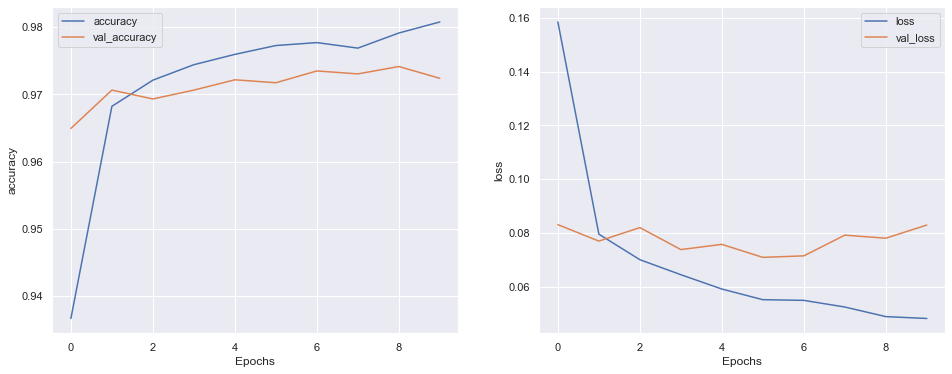

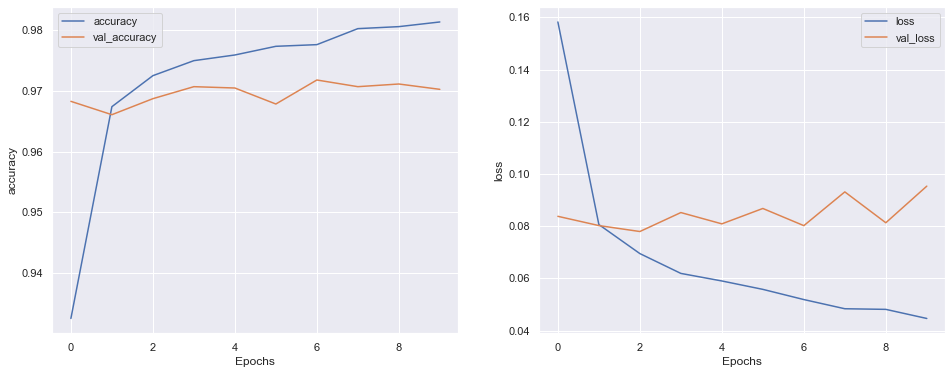

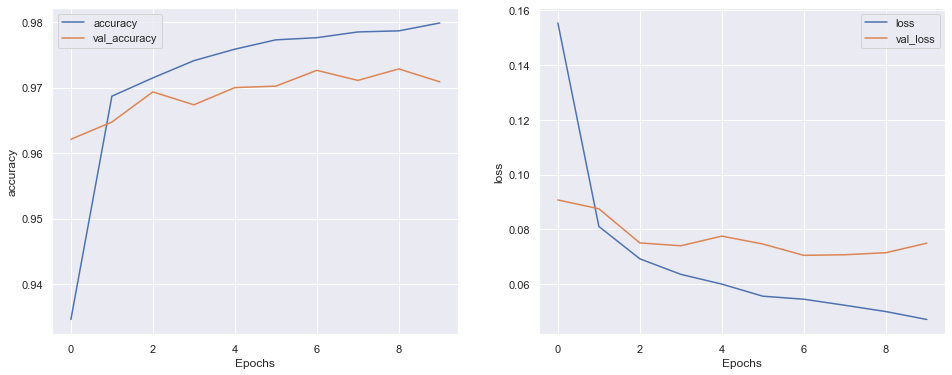

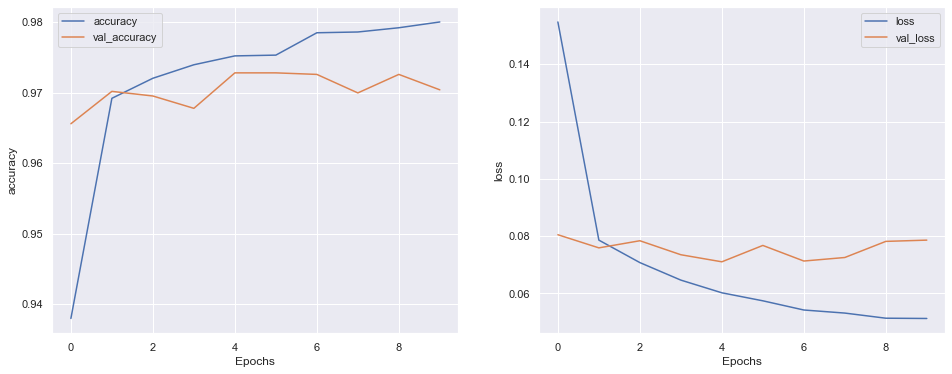

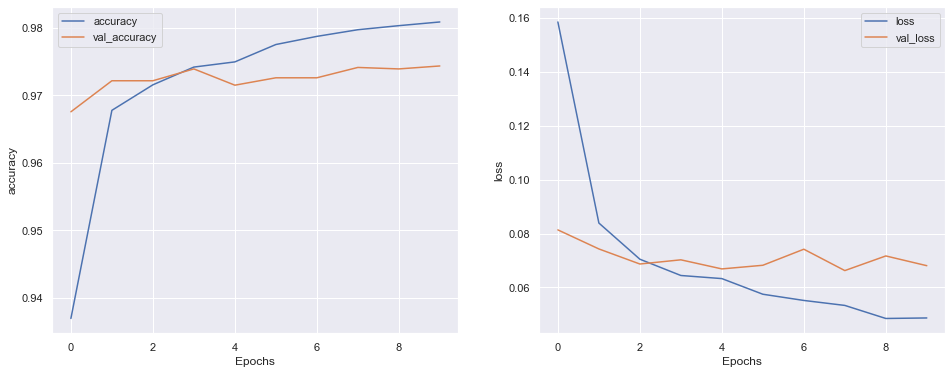

In [84]:
# Apply dropout to prevent overfitting.

vals = kfold.split(x_train, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train[train_i]
    x_train_val = x_train[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    model2 = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=50,
            mask_zero=True),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    history = model2.fit(x_train_train,y_train_train,
                         epochs=10,
                         batch_size=10,
                         verbose=1,
                         validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model2.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

### Still overfitting

In [85]:
from tensorflow.keras import regularizers

In [86]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 16s 9ms/step - loss: 0.2174 - accuracy: 0.9301 - val_loss: 0.1002 - val_accuracy: 0.9689
Epoch 2/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0998 - accuracy: 0.9675 - val_loss: 0.1062 - val_accuracy: 0.9604
Epoch 3/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0868 - accuracy: 0.9709 - val_loss: 0.0808 - val_accuracy: 0.9731
Epoch 4/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0793 - accuracy: 0.9729 - val_loss: 0.0780 - val_accuracy: 0.9713
Epoch 5/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0740 - accuracy: 0.9747 - val_loss: 0.0788 - val_accuracy: 0.9713
Epoch 6/10
1826/1826 [==============================] - 15s 8ms/step - loss: 0.0706 - accuracy: 0.9752 - val_loss: 0.0771 - val_accuracy: 0.9700
Epoch 7/10
1826/1826 [===========

Epoch 10/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0935 - accuracy: 0.9711
Test Loss: 0.09347598254680634
Test Accuracy: 0.9710843563079834


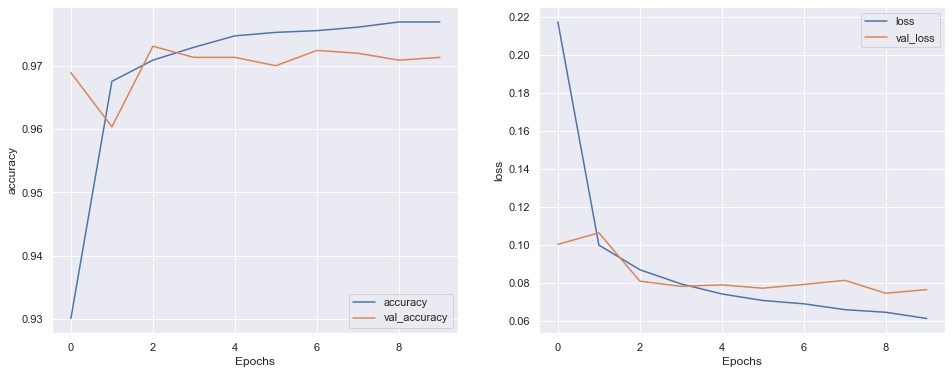

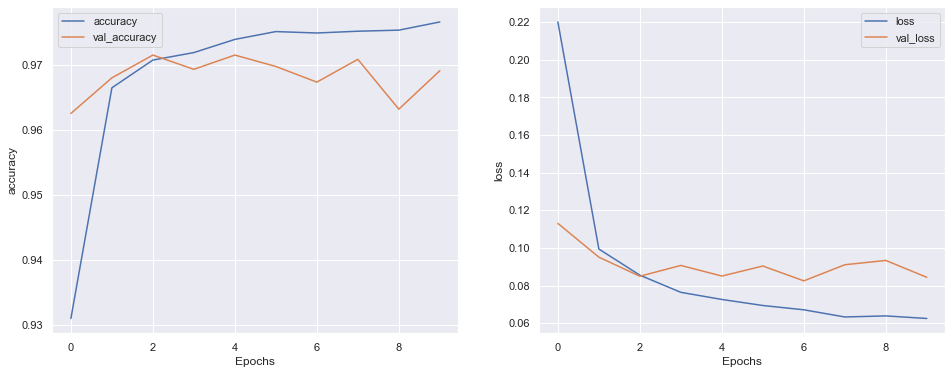

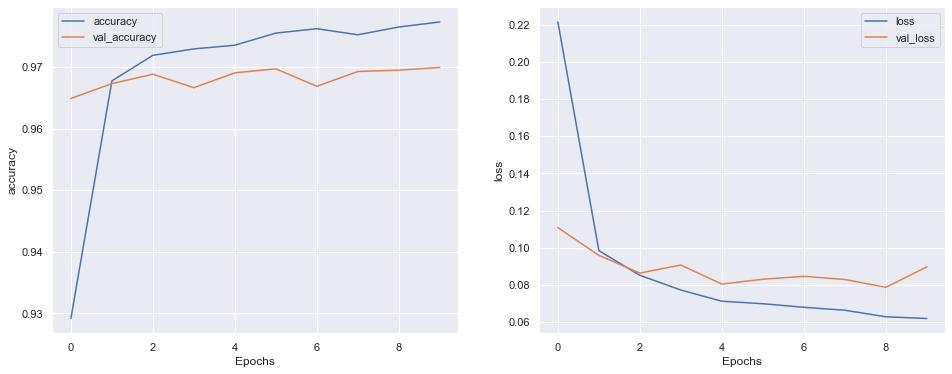

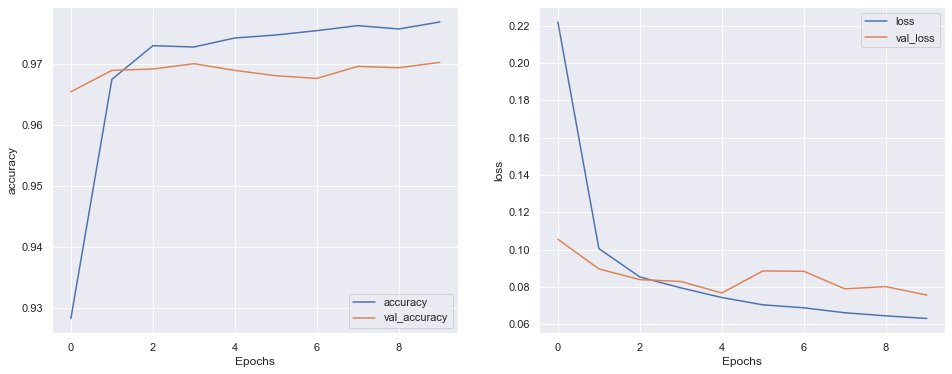

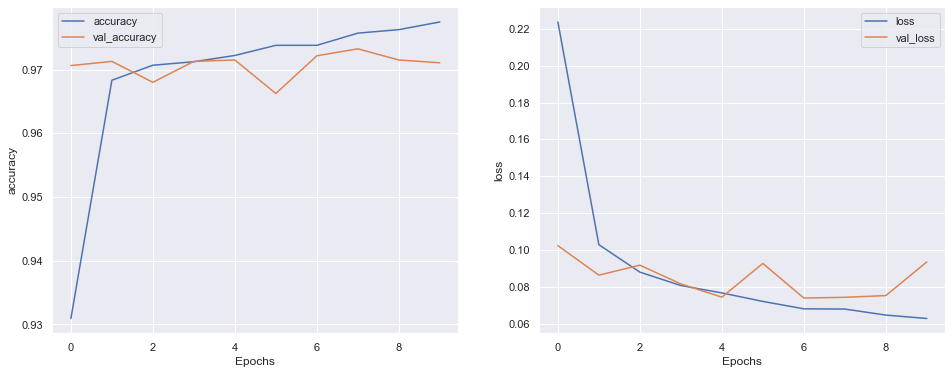

In [87]:
# Apply regularization, dropout, reduce hidden units.

vals = kfold.split(x_train, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train[train_i]
    x_train_val = x_train[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    model2 = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.LSTM(32, kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    history = model2.fit(x_train_train,y_train_train,
                         epochs=10,
                         batch_size=10,
                         verbose=1,
                         validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model2.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

### Better

In [88]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.07630052417516708 - Accuracy: 97.1303403377533%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0843949019908905 - Accuracy: 96.91128134727478%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.08968452364206314 - Accuracy: 96.99890613555908%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.0757155567407608 - Accuracy: 97.02081084251404%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.09347598254680634 - Accuracy: 97.10843563079834%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.03395485877991% (+- 0.0791043798349968)
> Loss: 0.08391429781913758
------------------------

In [89]:
# Predict
pred_labels_model2 = model2.predict(x_test)
pred_labels_model2

array([[1.0000000e+00],
       [1.0000000e+00],
       [6.4091146e-06],
       ...,
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [90]:
# Decision boundary
pred_labels_model2 = np.where(pred_labels_model2< 0.5, 0, pred_labels_model2)
pred_labels_model2 = np.where(pred_labels_model2 >= 0.5, 1, pred_labels_model2)
pred_labels_model2 = pred_labels_model2.astype(int)
pred_labels_model2[0:10]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1]])

In [91]:
# Convert the number labels back to strings
pred_labels_model2 = pred_labels_model2.astype(str)
pred_labels_model2 = np.where(pred_labels_model2 == '0', 'python', pred_labels_model2)
pred_labels_model2 = np.where(pred_labels_model2 == '1', 'nba', pred_labels_model2)
pred_labels_model2[0:10]

array([['nba'],
       ['nba'],
       ['python'],
       ['python'],
       ['python'],
       ['python'],
       ['nba'],
       ['nba'],
       ['python'],
       ['nba']], dtype='<U11')

In [92]:
y_test_array = np.array(y_test)
y_test_array[0:10]

array(['nba', 'nba', 'python', 'python', 'python', 'python', 'nba', 'nba',
       'python', 'nba'], dtype='<U6')

Text(84.453125, 0.5, 'predicted label')

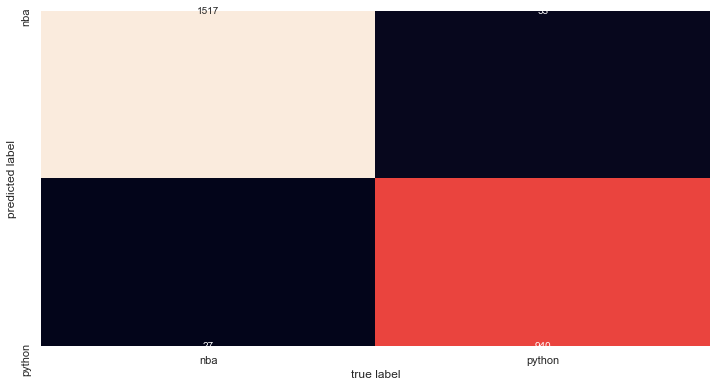

In [93]:
# Heatmap
mat = confusion_matrix(y_test_array, pred_labels_model2)
plt.figure(figsize=(12,12))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')


In [94]:
info = []

# F1 scores
print("Long Short-Term Memory Recurrent Neural Network: ")
print("Microaveraged F1 scores:", f1_score(y_test_array, pred_labels_model2, average='micro'))
info.append(f1_score(y_test_array, pred_labels_model2, average='micro'))
print("Macroaveraged F1 scores", f1_score(y_test_array, pred_labels_model2, average="macro"))
info.append(f1_score(y_test_array, pred_labels_model2, average="macro"))

models_eval['RNN LSTM Tensorflow']=info

Long Short-Term Memory Recurrent Neural Network: 
Microaveraged F1 scores: 0.9684666929444226
Macroaveraged F1 scores 0.96674662157734


### 8.3.3 Model3: Bidirectional RNN

In [95]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 28s 15ms/step - loss: 0.1302 - accuracy: 0.9459 - val_loss: 0.0872 - val_accuracy: 0.9660
Epoch 2/10
1826/1826 [==============================] - 27s 15ms/step - loss: 0.0705 - accuracy: 0.9712 - val_loss: 0.0730 - val_accuracy: 0.9702
Epoch 3/10
1826/1826 [==============================] - 27s 15ms/step - loss: 0.0578 - accuracy: 0.9765 - val_loss: 0.0725 - val_accuracy: 0.9702
Epoch 4/10
1826/1826 [==============================] - 26s 14ms/step - loss: 0.0495 - accuracy: 0.9801 - val_loss: 0.0699 - val_accuracy: 0.9722
Epoch 5/10
1826/1826 [==============================] - 27s 15ms/step - loss: 0.0410 - accuracy: 0.9837 - val_loss: 0.0703 - val_accuracy: 0.9711curacy: 
Epoch 6/10
1826/1826 [==============================] - 29s 16ms/step - loss: 0.0325 - accuracy: 0.9875 - val_loss: 0.0768 - val_accuracy: 0.9715
Epoch 7/10
1826/182

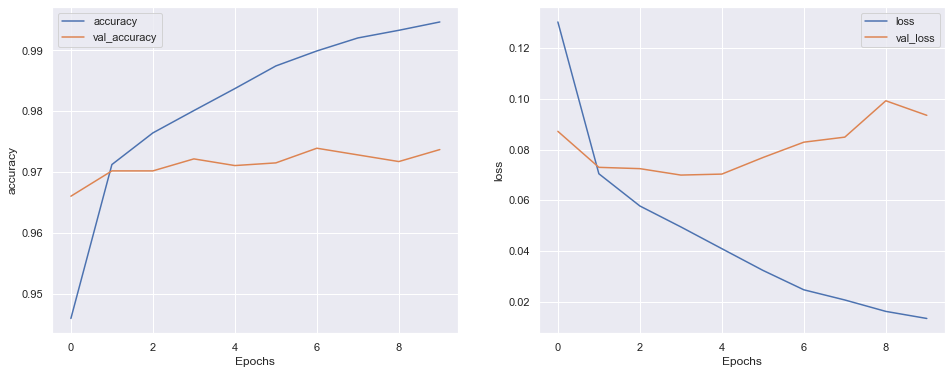

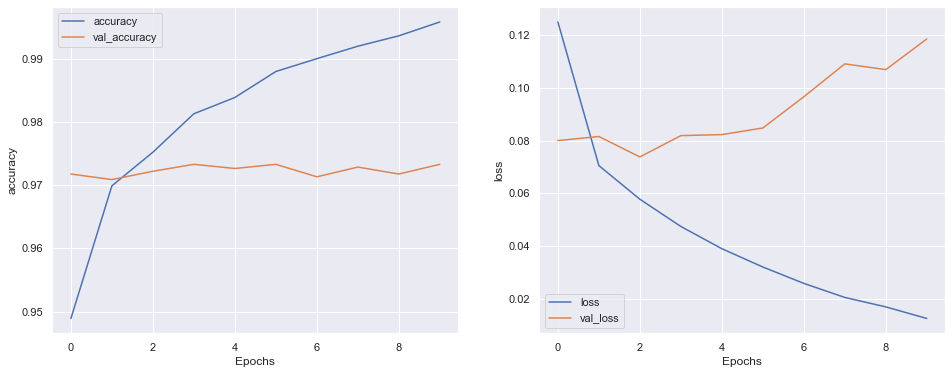

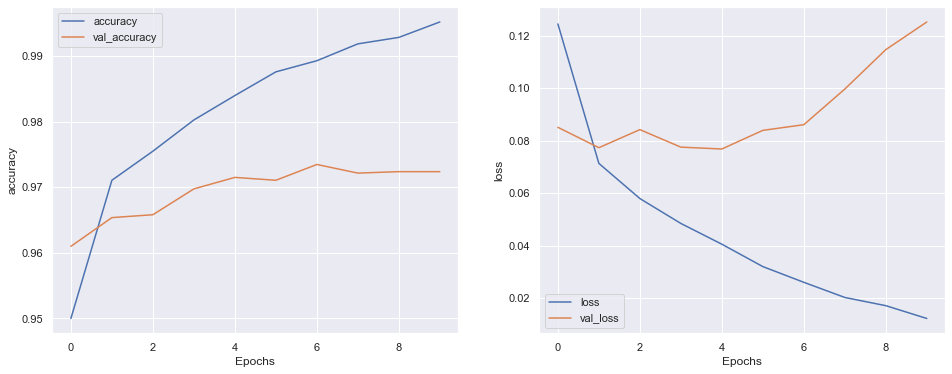

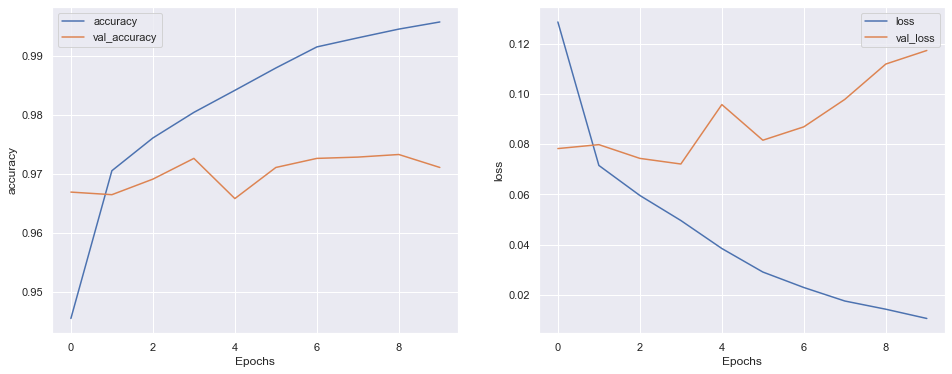

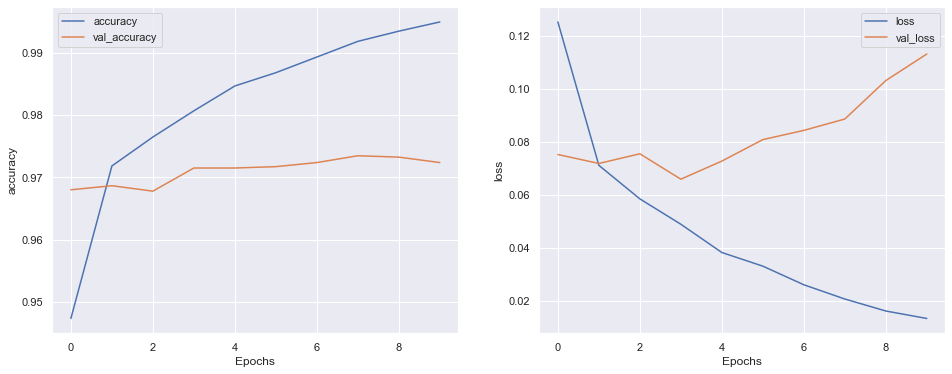

In [96]:
vals = kfold.split(x_train, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train[train_i]
    x_train_val = x_train[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    model3 = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=50,
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    history = model3.fit(x_train_train,y_train_train,
                         epochs=10,
                         batch_size=10,
                         verbose=1,
                         validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model3.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

### Above is overfitting

In [97]:
# 5 fold cross validation
kfold = KFold(n_splits=5)

# Count fold
fold_n = 1

# Record accuracy and loss every fold.
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1826/1826 [==============================] - 20s 11ms/step - loss: 0.2391 - accuracy: 0.9232 - val_loss: 0.1025 - val_accuracy: 0.9691
Epoch 2/10
1826/1826 [==============================] - 18s 10ms/step - loss: 0.1066 - accuracy: 0.9658 - val_loss: 0.0922 - val_accuracy: 0.9700
Epoch 3/10
1826/1826 [==============================] - 17s 9ms/step - loss: 0.0917 - accuracy: 0.9674 - val_loss: 0.0898 - val_accuracy: 0.9691
Epoch 4/10
1826/1826 [==============================] - 18s 10ms/step - loss: 0.0850 - accuracy: 0.9710 - val_loss: 0.0817 - val_accuracy: 0.9731
Epoch 5/10
1826/1826 [==============================] - 18s 10ms/step - loss: 0.0781 - accuracy: 0.9728 - val_loss: 0.0853 - val_accuracy: 0.9722
Epoch 6/10
1826/1826 [==============================] - 18s 10ms/step - loss: 0.0767 - accuracy: 0.9735 - val_loss: 0.0799 - val_accuracy: 0.9698
Epoch 7/10
1826/1826 [======

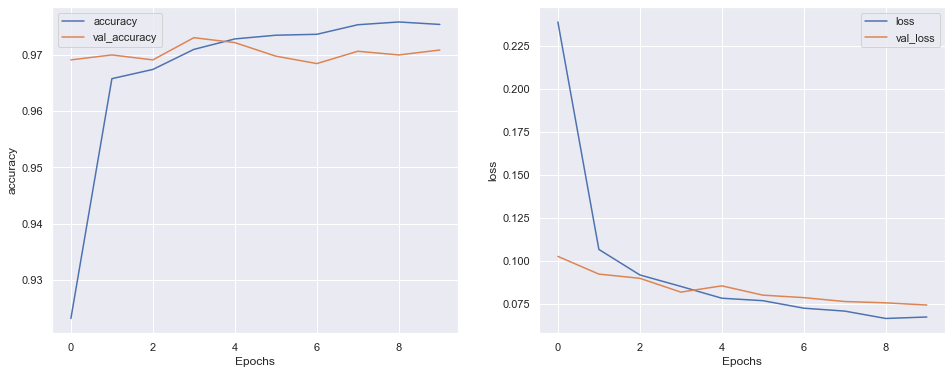

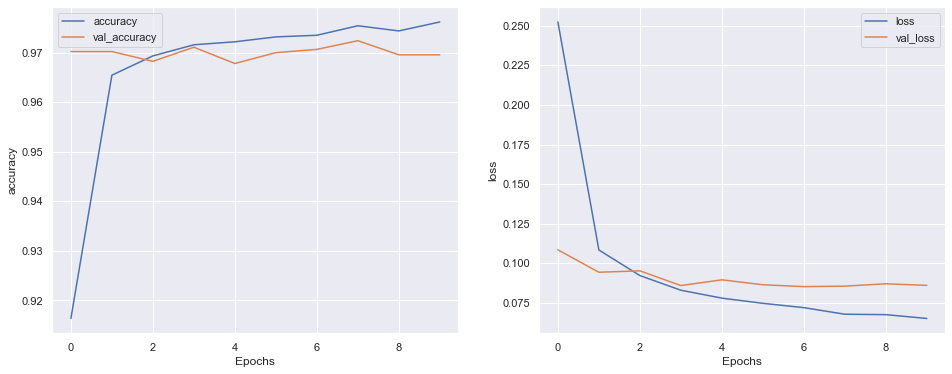

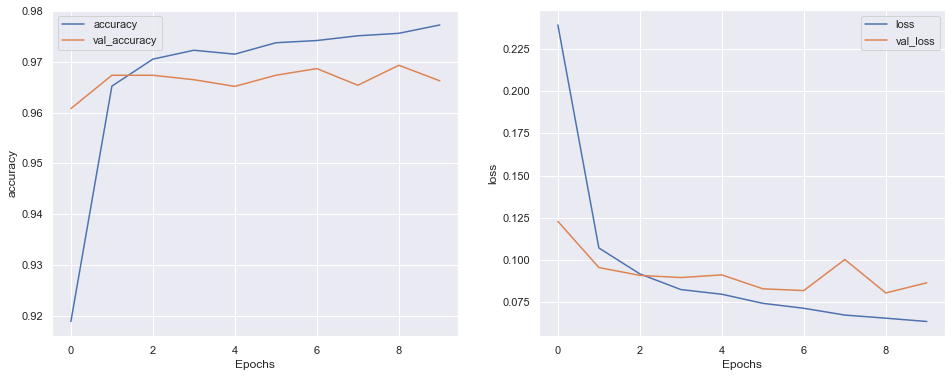

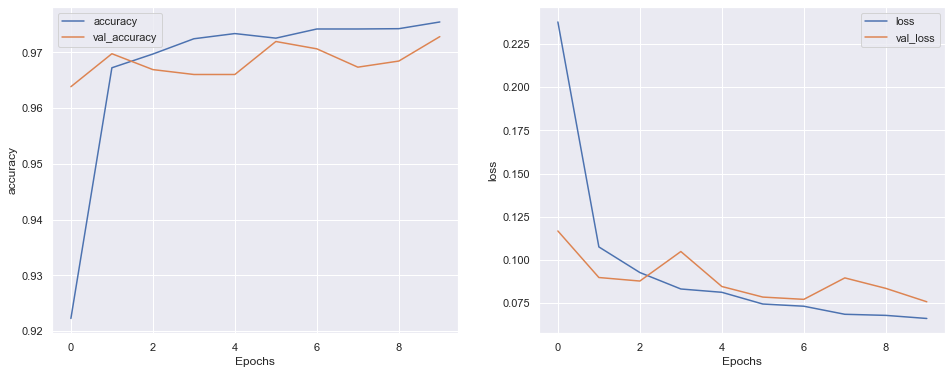

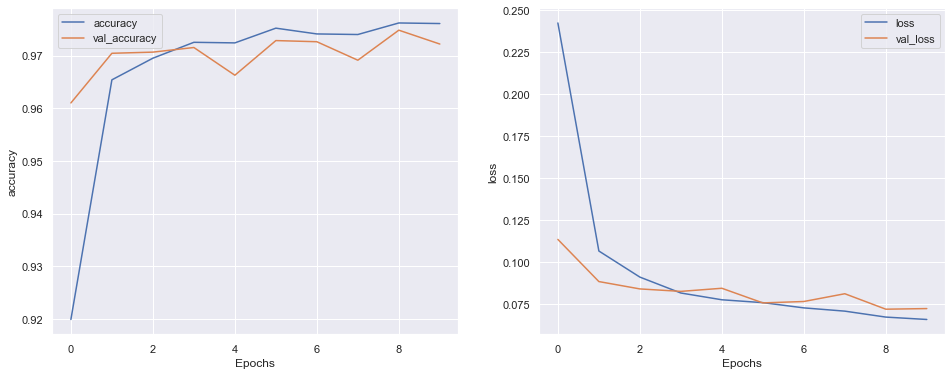

In [98]:
# Apply regularization, dropout to prevent overfitting.

vals = kfold.split(x_train, y_train_a)

for train_i, val_i in vals:
    x_train_train = x_train[train_i]
    x_train_val = x_train[val_i]
    y_train_train = y_train_a[train_i]
    y_train_val = y_train_a[val_i]
    
    model3 = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=50,
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, kernel_regularizer=regularizers.l2(0.01))),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_n} ...')


    history = model3.fit(x_train_train,y_train_train,
                         epochs=10,
                         batch_size=10,
                         verbose=1,
                         validation_data = (x_train_val,y_train_val))
    
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')

    test_loss, test_acc = model3.evaluate(x_train_val, y_train_val)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc)) 
    
    acc_per_fold.append(test_acc * 100)
    loss_per_fold.append(test_loss)
    
    # Increase fold number
    fold_n = fold_n + 1

### A lot better

In [99]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.07416100054979324 - Accuracy: 97.0865249633789%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0859663337469101 - Accuracy: 96.95509076118469%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0865386351943016 - Accuracy: 96.6265082359314%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.075940802693367 - Accuracy: 97.28367924690247%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.07216670364141464 - Accuracy: 97.2179651260376%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.03395366668701% (+- 0.23290253786940207)
> Loss: 0.07895469516515732
---------------------------

In [100]:
# Predict
pred_labels_model3 = model3.predict(x_test)
pred_labels_model3

array([[9.9999869e-01],
       [9.9996567e-01],
       [1.0486752e-05],
       ...,
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999511e-01]], dtype=float32)

In [101]:
# Decision boundary
pred_labels_model3 = np.where(pred_labels_model3< 0.5, 0, pred_labels_model3)
pred_labels_model3 = np.where(pred_labels_model3 >= 0.5, 1, pred_labels_model3)
pred_labels_model3 = pred_labels_model3.astype(int)
2
pred_labels_model3 = pred_labels_model3.astype(str)
pred_labels_model3[0:10]

array([['1'],
       ['1'],
       ['0'],
       ['0'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['1']], dtype='<U11')

In [102]:
# Convert the number labels back to strings
pred_labels_model3 = pred_labels_model3.astype(str)
pred_labels_model3 = np.where(pred_labels_model3 == '0', 'python', pred_labels_model3)
pred_labels_model3 = np.where(pred_labels_model3 == '1', 'nba', pred_labels_model3)
pred_labels_model3[0:10]

array([['nba'],
       ['nba'],
       ['python'],
       ['python'],
       ['python'],
       ['python'],
       ['nba'],
       ['nba'],
       ['python'],
       ['nba']], dtype='<U11')

In [103]:
y_test_array = np.array(y_test)
y_test_array[0:10]

array(['nba', 'nba', 'python', 'python', 'python', 'python', 'nba', 'nba',
       'python', 'nba'], dtype='<U6')

Text(84.453125, 0.5, 'predicted label')

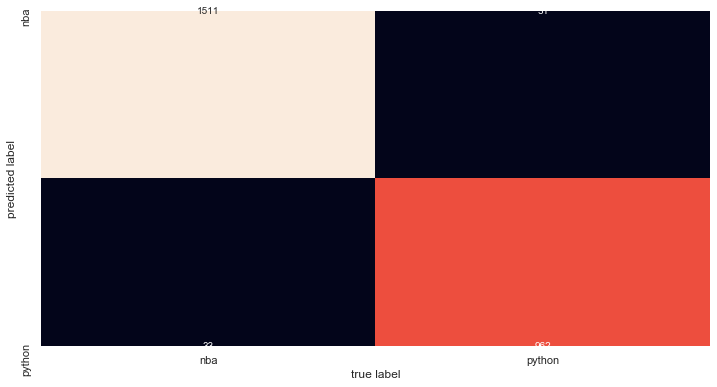

In [104]:
# Heatmap
mat = confusion_matrix(y_test_array, pred_labels_model3)
plt.figure(figsize=(12,12))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')


In [105]:
info = []

# F1 scores
print("Bidirectional LSTM Recurrent Neural Network: ")
print("Microaveraged F1 scores:", f1_score(y_test_array, pred_labels_model3, average='micro'))
info.append(f1_score(y_test_array, pred_labels_model3, average='micro'))
print("Macroaveraged F1 scores", f1_score(y_test_array, pred_labels_model3, average="macro"))
info.append(f1_score(y_test_array, pred_labels_model3, average="macro"))

models_eval['RNN Bidirectional LSTM Tensorflow']=info



Bidirectional LSTM Recurrent Neural Network: 
Microaveraged F1 scores: 0.974773354355538
Macroaveraged F1 scores 0.9735340102833462


In [106]:
data = []
for k,v in models_eval.items():
    info = []
    info.append(k)
    for n in v:
        info.append(n)
    data.append(info)

df = pd.DataFrame(data, columns = ['Model', 'Microaveraged F1', 'Macroaveraged F1 scores'])
df

,Model,Microaveraged F1,Macroaveraged F1 scores
0,Naive Bayes TF-IDF,0.972518,0.971060
1,Logistic Regression TF-IDF,0.977289,0.976234
2,Logistic Regression Word Embeddings,0.937347,0.934669
3,Neural Network TF-IDF,0.986082,0.985400
4,Neural Network Word Embeddings,0.958402,0.953885
5,Neural Network 1 Layer Tensorflow,0.953094,0.950903
6,Neural Network 3 Layer Tensorflow,0.953488,0.950742
7,RNN LSTM Tensorflow,0.968467,0.966747
8,RNN Bidirectional LSTM Tensorflow,0.974773,0.973534
